## **Predicción del Riesgo de Readmisión en Pacientes Diabeticos:**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OrdinalEncoder
import numpy as np
import math
from scipy.stats import mannwhitneyu, kruskal
from scipy.stats import chi2_contingency
from statsmodels.stats.outliers_influence import variance_inflation_factor
from scipy.stats import kstest, norm
import statsmodels.api as sm
from scipy.stats import levene
from scipy.stats import spearmanr
import missingno as msno


# Configuración estética opcional
sns.set(style="whitegrid")
plt.rcParams["figure.figsize"] = (10, 6)

# Cargar los datos
df = pd.read_csv("diabetic_data.csv")

## **Funciones:**

In [2]:
def mostrar_faltantes(df):
    faltantes = df.isnull().sum()
    porcentaje = (faltantes / len(df)) * 100

    tabla_faltantes = pd.DataFrame({
        'Valores faltantes': faltantes,
        'Porcentaje (%)': porcentaje
    })

    # Mostrar solo columnas con NA
    tabla_faltantes = tabla_faltantes[tabla_faltantes['Valores faltantes'] > 0]
    tabla_faltantes.sort_values('Porcentaje (%)', ascending=False)
    return tabla_faltantes

## **1. ETL (Extract, Transform, Load):**

### **1.1 Origen y tamaño del Dataset:**

Los datos provienen del UCI Machine Learning Repository, en el conjunto “Diabetes 130-US hospitals for years 1999–2008 Data Set”, recopilado de registros hospitalarios electrónicos de 130 hospitales y redes médicas en EE.UU.

[UCI Machine Learning Repository - Diabetes 130-US hospitals for years 1999–2008](https://archive.ics.uci.edu/dataset/296/diabetes+130-us+hospitals+for+years+1999-2008)


In [3]:
print("Filas:", df.shape[0])
print("Columnas:", df.shape[1])

Filas: 101766
Columnas: 50


Este dataset cuenta con un total de 50 variables y 101766 registros.

### **1.2 Tipos de Variables:**

In [4]:
# Resumen de tipos de datos
df.dtypes.value_counts()

object    37
int64     13
Name: count, dtype: int64

De forma general tenemos 37 variables categoricas y 13 variables numéricas, de las cuales detallando un poco mas tenemos:

| Tipo de variable | Cantidad | Ejemplos | Descripción |
|------------------|-----------|-----------|--------------|
| **Numéricas** | 10 | `encounter_id`, `patient_nbr`, `time_in_hospital`, `num_lab_procedures`, `num_procedures`, `num_medications`, `number_outpatient`, `number_emergency`, `number_inpatient`, `number_diagnoses` | Variables de conteo o identificación que representan cantidades o códigos numéricos. |
| **Categóricas** | 38 | `race`, `gender`, `age`, `weight`, `diag_1`, `diag_2`, `diag_3`, `medical_specialty`, `max_glu_serum`, `A1Cresult`, `change`, `diabetesMed`, entre otras relacionadas con medicamentos | Variables que representan grupos, categorías o niveles cualitativos. |
| **Categóricas codificadas (numéricas con significado categórico)** | 3 | `admission_type_id`, `discharge_disposition_id`, `admission_source_id` | Contienen códigos numéricos que representan categorías (por ejemplo, tipo o fuente de admisión). |
| **Variable objetivo** | 1 | `readmitted` | Indica si el paciente fue readmitido (`<30`, `>30`, `No`). |

**Modo de Uso:**
- **Variables numéricas:** se usarán para análisis descriptivos cuantitativos, como promedios, desviaciones y detección de outliers.

- **Variables categóricas y codificadas:** se emplearán para análisis de frecuencia, gráficos de barras y agrupaciones.

- **Variable objetivo (readmitted):** será el eje central del análisis predictivo y comparativo.

- **Identificadores:** (encounter_id, patient_nbr) no se incluirán en los análisis estadísticos ni en los modelos.


### **1.3 Observando el Dataset:**

In [5]:
# Mostrar todas las columnas al imprimir
pd.set_option('display.max_columns', None)

# Mostrar las primeras filas del DataFrame
df.head()

encounter_id  patient_nbr             race  gender      age weight  \
0       2278392      8222157        Caucasian  Female   [0-10)      ?   
1        149190     55629189        Caucasian  Female  [10-20)      ?   
2         64410     86047875  AfricanAmerican  Female  [20-30)      ?   
3        500364     82442376        Caucasian    Male  [30-40)      ?   
4         16680     42519267        Caucasian    Male  [40-50)      ?   

   admission_type_id  discharge_disposition_id  admission_source_id  \
0                  6                        25                    1   
1                  1                         1                    7   
2                  1                         1                    7   
3                  1                         1                    7   
4                  1                         1                    7   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1          ?  Pediatrics-Endocrinology                  41   
1                 3          ?                         ?                  59   
2                 2          ?                         ?                  11   
3                 2          ?                         ?                  44   
4                 1          ?                         ?                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83       ?      ?                 1           NaN   
1                 0     276  250.01    255                 9           NaN   
2                 1     648     250    V27                 6           NaN   
3                 0       8  250.43    403                 7           NaN   
4                 0     197     157    250                 5           NaN   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0       NaN        No          No          No             No          No   
1       NaN        No          No          No             No          No   
2       NaN        No          No          No             No          No   
3       NaN        No          No          No             No          No   
4       NaN        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4        

In [6]:
import numpy as np

def agrupar_admission_source(x):
    if x in [1, 2, 3]:
        return "Referral"
    elif x in [4, 5, 6, 10, 22, 25, 26]:
        return "Transfer"
    elif x == 7:
        return "EmergencyRoom"
    elif x == 8:
        return "Legal/Court"
    elif x in [11, 12, 13, 14, 23, 24]:
        return "Newborn"
    elif x in [18, 19]:
        return "HomeHealthCare"
    elif x in [9, 15, 17, 20, 21]:
        return "Unknown"
    else:
        return np.nan

df["admission_source_id"] = df["admission_source_id"].apply(agrupar_admission_source)


# Reemplazar valores no informativos por NaN
df["admission_source_id"] = df["admission_source_id"].replace(
    "Unknown", np.nan
)

# Verificar resultado
df["admission_source_id"].value_counts(dropna=False).head(5)

admission_source_id
EmergencyRoom    57494
Referral         30856
NaN               7067
Transfer          6328
Legal/Court         16
Name: count, dtype: int64

In [7]:
import numpy as np

def agrupar_discharge(x):
    if x in [1, 6, 8]:
        return "Home"
    elif x in [2, 9, 16, 17, 22, 27, 28, 29, 30]:
        return "Transferred"
    elif x in [3, 4, 5, 15, 23, 24]:
        return "ExtendedCare"
    elif x in [13, 14, 19, 20, 21]:
        return "Hospice/Expired"
    elif x == 7:
        return "LeftAMA"
    elif x == 11:
        return "Expired"
    elif x == 12:
        return "StillPatient"
    elif x in [18, 25, 26]:
        return "Unknown"
    else:
        return np.nan

df["discharge_disposition_id"] = df["discharge_disposition_id"].apply(agrupar_discharge)

# Reemplazar valores no informativos por NaN
df["discharge_disposition_id"] = df["discharge_disposition_id"].replace(
   "Unknown", np.nan
)

# Verificar resultado
df["discharge_disposition_id"].value_counts(dropna=False).head(10)


discharge_disposition_id
Home               73244
ExtendedCare       16476
NaN                 4686
Transferred         4311
Expired             1642
Hospice/Expired      781
LeftAMA              623
StillPatient           3
Name: count, dtype: int64

In [8]:
admission_map = {
    1: "Emergency",
    2: "Urgent",
    3: "Elective",
    4: "Newborn",
    5: None,           # Not Available -> NA
    6: None,           # NULL -> NA
    7: "Trauma Center",
    8: None            # Not Mapped -> NA
}


# Crear nueva columna con la descripción
df['admission_type_id'] = df['admission_type_id'].map(admission_map)

# Verifica el resultado
df["admission_type_id"].value_counts(dropna=False).head(10)

admission_type_id
Emergency        53990
Elective         18869
Urgent           18480
None             10396
Trauma Center       21
Newborn             10
Name: count, dtype: int64

### **1.4 Variables Faltantes (NA) y Duplicados:**

#### **1.4.1 Valores Faltantes:**

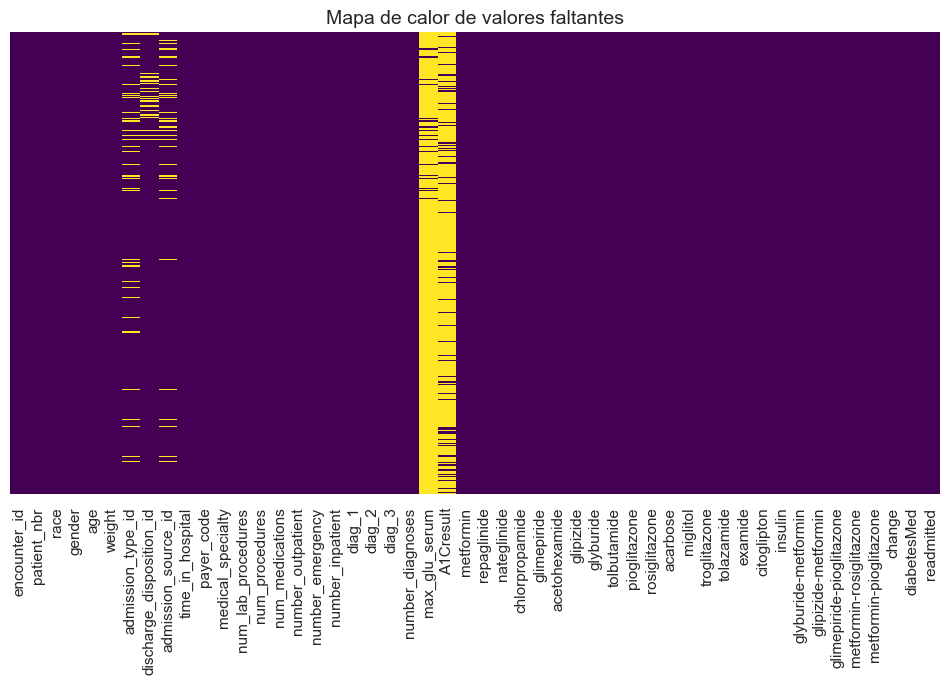

In [9]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Mapa de calor de valores faltantes", fontsize=14)
plt.show()

In [10]:
mostrar_faltantes(df)

Valores faltantes  Porcentaje (%)
admission_type_id                     10396       10.215593
discharge_disposition_id               4686        4.604681
admission_source_id                    7067        6.944363
max_glu_serum                         96420       94.746772
A1Cresult                             84748       83.277322

En este análisis identificamos variables que las variables **`admission_type_id`**,
**`discharge_disposition_id`**,**`admission_source_id`**, ***`max_glu_serum`*** y ***`A1Cresult`***, presentaban valores ausentes. Estas dos ultimas con un 94.74% y 83.27% de valores faltantes respectivamente. A primera vista, esta alta proporción de NaN sugeriría que estas variables deberían eliminarse del análisis.

Sin embargo, al examinar más a fondo el contexto del dataset, notamos que ambas variables son categóricas y contienen una categoría denominada "None", la cual fue erróneamente interpretada por Python como un valor nulo. (vealo en la siguiente tabla)

| Variable       | Tipo       | Descripción |
|----------------|------------|-------------|
| `max_glu_serum`| Categórica | Resultado máximo de glucosa en suero. Valores: >200, >300, normal, ***none***. |
| `A1Cresult`    | Categórica | Resultado de hemoglobina A1C. Valores: >8, >7, normal, ***none***. |

Adicionalmente, descubrimos que en este conjunto de datos los valores realmente faltantes se representan mediante el símbolo "?", por lo que no son detectados automáticamente como nulos al cargar el archivo. (Vealo en la siguiente Imagen)

![Mapa de calor de valores faltantes](Imagenes/Valores_Faltantes_Datos.png)

El paso a seguir es reemplazar manualmente estos símbolos para permitir un tratamiento adecuado de los valores ausentes en etapas posteriores del análisis.

In [11]:
#Se reemplaza los "na" que en realidad son una categoria por el string none
df['max_glu_serum'] = df['max_glu_serum'].fillna('none')
df['A1Cresult'] =df['A1Cresult'].fillna('none')

# Reemplazar '?' por NaN
df= df.replace('?', np.nan)

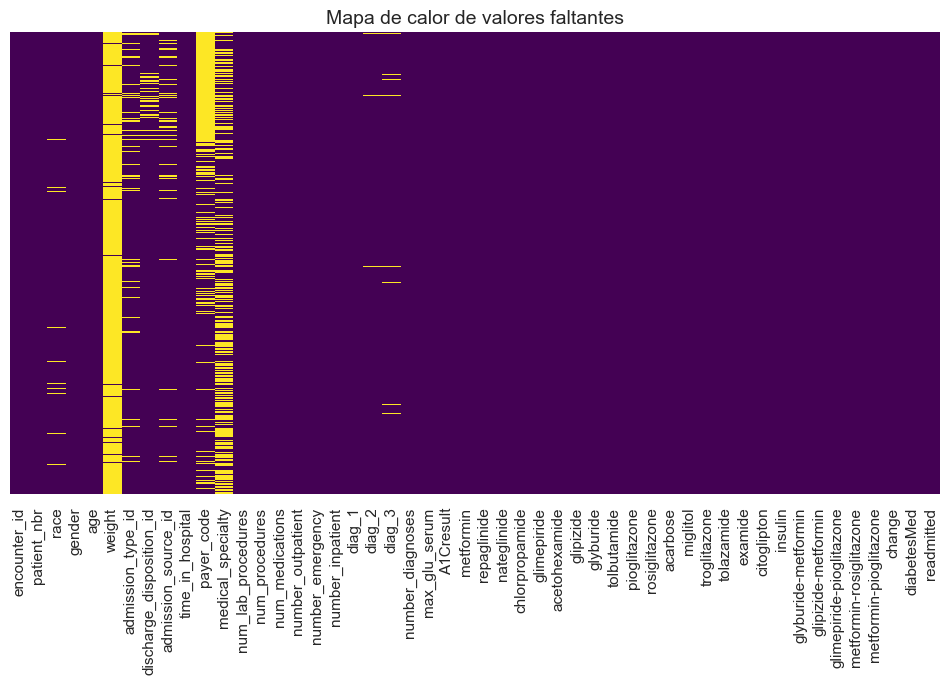

In [12]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Mapa de calor de valores faltantes", fontsize=14)
plt.show()

In [13]:
mostrar_faltantes(df)

Valores faltantes  Porcentaje (%)
race                                   2273        2.233555
weight                                98569       96.858479
admission_type_id                     10396       10.215593
discharge_disposition_id               4686        4.604681
admission_source_id                    7067        6.944363
payer_code                            40256       39.557416
medical_specialty                     49949       49.082208
diag_1                                   21        0.020636
diag_2                                  358        0.351787
diag_3                                 1423        1.398306

Ahora observamos que la variable ***weight*** presenta un ***96.86%*** de datos faltantes. Dado que este porcentaje es extremadamente alto, cualquier técnica de imputación resultaría ineficiente y podría introducir sesgos significativos en el análisis, comprometiendo la validez de los resultados. Por esta razón, se decide excluir esta variable del análisis.

En el caso de las variables ***medical_specialty*** y ***payer_code***, los porcentajes de valores faltantes son de ***49.08%*** y ***39.55%***, respectivamente. Estos porcentajes no son lo suficientemente bajos como para aplicar técnicas de imputación sin riesgo de introducir sesgos, pero tampoco tan altos como para justificar directamente su eliminación del análisis. Por tanto, recurriremos a agrupar estos NaN es una nueva categoria llamada ***"Unknown"***.

Las variables ***race***, ***diag_1***, ***diag_2***, ***diag_3***,***admission_type_id***, ***discharge_disposition_id***, ***admission_source_id*** tienen un porcentaje de NaN del ***2.23%***, ***1.29%***, ***0.35%***, ***0.02%***, ***6.94%***, ***4.59%*** y ***10.21%*** respectivamente. Al ser porcentajes  pequeños recurriremos a hacer imputación por la moda para todos los casos.

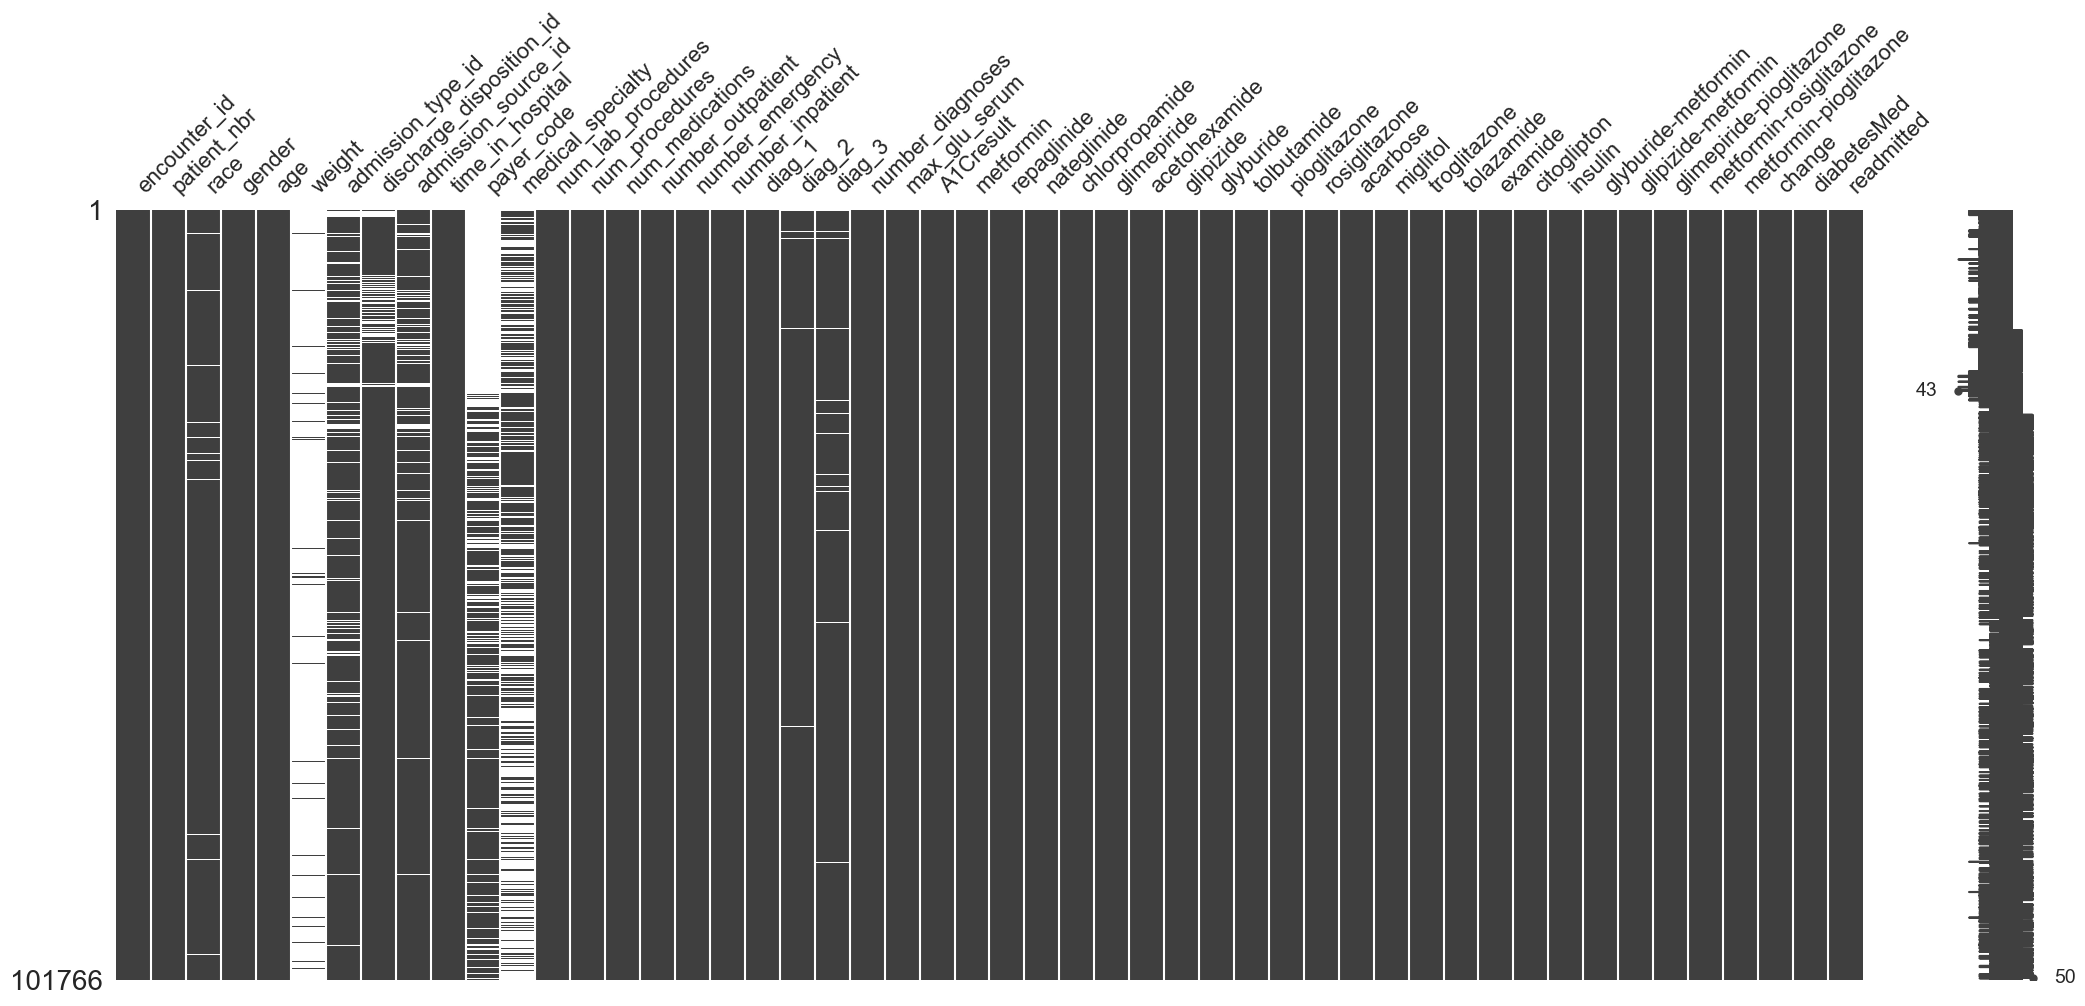

In [14]:
# Matriz visual general
msno.matrix(df)
plt.show()

En el gráfico se observa que la mayoría de las columnas presentan un patrón denso y uniforme, indicando una buena completitud general. Sin embargo, se identifican columnas con amplias franjas negras o espacios vacíos, lo que evidencia un porcentaje alto de valores faltantes, especialmente en variables como `weight`, `medical_specialty` y `payer_code`.  
El patrón irregular en estas columnas sugiere que los datos faltantes no se distribuyen de forma completamente aleatoria, sino que podrían depender de otras variables del contexto médico o administrativo, lo que apunta a un mecanismo de tipo **MAR (Missing At Random)**.


In [15]:
# Gráfico tipo "bar" del conteo de faltantes
msno.bar(df)
plt.show()

El gráfico de barras muestra el número total de valores faltantes por variable. Se evidencia que la variable `weight` concentra el mayor número de datos ausentes, superando el 95% del total, seguida de `medical_specialty` y `payer_code` con porcentajes intermedios. El resto de las variables presenta un nivel bajo o nulo de ausencia, lo que indica una estructura de datos relativamente completa en la mayoría de los campos.  
El alto nivel de omisión en `weight` puede deberse a que el peso no siempre se considera un dato clínico relevante o se omite por falta de registro sistemático, lo cual sugiere un mecanismo **MAR**, condicionado al tipo de atención o especialidad médica. En cambio, los pequeños porcentajes en otras variables pueden clasificarse como **MCAR**, es decir, faltantes completamente al azar.


#### **1.4.2. Análisis del tipo de valores faltantes:**

Al examinar el patrón de valores faltantes mediante visualizaciones de calor y gráficos generados anteriormente, se observa que la ausencia de datos se concentra principalmente en variables específicas como **`weight` (96.8%)**, **`medical_specialty` (49%)** y **`payer_code` (39.5%)**, mientras que el resto de las variables presentan porcentajes de omisión bajos y una distribución dispersa.

Este comportamiento permite inferir que el conjunto de datos contiene una combinación de mecanismos **MCAR** (*Missing Completely At Random*) y **MAR** (*Missing At Random*), sin evidencia clara de **MNAR** (*Missing Not At Random*).

- **MCAR (faltantes completamente al azar):** Variables como `race`, `diag_1`, `diag_2`, `diag_3` y algunas de tipo administrativo (`admission_disposition_id`, `admission_source_id`) presentan un porcentaje muy bajo de datos faltantes y no muestran un patrón asociado a otras variables. En estos casos, la falta de información parece deberse a errores de registro o pérdidas accidentales, por lo que se consideran valores faltantes completamente al azar (MCAR).

- **MAR (faltantes al azar condicionado a otras variables):** En el caso de `weight`, `payer_code` y `medical_specialty`, los valores ausentes presentan una frecuencia elevada y probablemente están relacionados con otras características observadas del paciente o del proceso de atención. Por ejemplo, es posible que el peso no se registre en ciertos tipos de ingreso hospitalario o en determinadas especialidades médicas; de igual forma, el código del pagador puede omitirse cuando la atención no depende de un seguro o cuando el registro administrativo no lo requiere. En estos escenarios, la omisión depende de variables observadas, por lo que se clasifica como **MAR**.

- **MNAR (faltantes no al azar):** No se identificaron patrones que sugieran que los datos faltan por causas asociadas al valor faltante en sí mismo, por lo tanto, no se evidencia un mecanismo MNAR.

En conclusión, el conjunto de datos presenta valores faltantes principalmente de tipo **MCAR y MAR**. Los faltantes de tipo MCAR se deben a errores o pérdidas aleatorias de información, mientras que los de tipo MAR parecen vinculados a factores administrativos y contextuales del registro clínico (por ejemplo, el tipo de ingreso o la especialidad médica). No existen indicios de valores faltantes MNAR.


##### **1.4.1.1. Tratamiento:**

In [16]:
df.drop(columns=['weight'], inplace=True) #Se elimina

#remplazamos los na por categorias dado que son porcentajes grandes o irrelevantes para imputar
df['medical_specialty'] = df['medical_specialty'].fillna('Unknown')
df['payer_code'] = df['payer_code'].fillna('Unknown')

#Imputación por la moda
var_imputar = ['race', 'diag_1', 'diag_2', 'diag_3', 'admission_type_id', 'discharge_disposition_id', 'admission_source_id']
for name_var in var_imputar:
    moda = df[name_var].mode()[0]
    df[name_var] = df[name_var].fillna(moda)

df.head()    

encounter_id  patient_nbr             race  gender      age  \
0       2278392      8222157        Caucasian  Female   [0-10)   
1        149190     55629189        Caucasian  Female  [10-20)   
2         64410     86047875  AfricanAmerican  Female  [20-30)   
3        500364     82442376        Caucasian    Male  [30-40)   
4         16680     42519267        Caucasian    Male  [40-50)   

  admission_type_id discharge_disposition_id admission_source_id  \
0         Emergency                     Home            Referral   
1         Emergency                     Home       EmergencyRoom   
2         Emergency                     Home       EmergencyRoom   
3         Emergency                     Home       EmergencyRoom   
4         Emergency                     Home       EmergencyRoom   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1    Unknown  Pediatrics-Endocrinology                  41   
1                 3    Unknown                   Unknown                  59   
2                 2    Unknown                   Unknown                  11   
3                 2    Unknown                   Unknown                  44   
4                 1    Unknown                   Unknown                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83     276    250                 1          none   
1                 0     276  250.01    255                 9          none   
2                 1     648     250    V27                 6          none   
3                 0       8  250.43    403                 7          none   
4                 0     197     157    250                 5          none   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0      none        No          No          No             No          No   
1      none        No          No          No             No          No   
2      none        No          No          No             No          No   
3      none        No          No          No             No          No   
4      none        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4                  No                  No                       No   

In [17]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title("Mapa de calor de valores faltantes", fontsize=14)
plt.show()

#### **1.4.3. Valores Duplicados:**

In [18]:
# Contar filas completamente duplicadas
duplicados_totales = df.duplicated().sum()
print("Duplicados totales en el dataset:", duplicados_totales)

# Si quieres ver cuáles son, puedes mostrarlos:
df[df.duplicated(keep=False)].head()


Duplicados totales en el dataset: 0


Empty DataFrame
Columns: [encounter_id, patient_nbr, race, gender, age, admission_type_id, discharge_disposition_id, admission_source_id, time_in_hospital, payer_code, medical_specialty, num_lab_procedures, num_procedures, num_medications, number_outpatient, number_emergency, number_inpatient, diag_1, diag_2, diag_3, number_diagnoses, max_glu_serum, A1Cresult, metformin, repaglinide, nateglinide, chlorpropamide, glimepiride, acetohexamide, glipizide, glyburide, tolbutamide, pioglitazone, rosiglitazone, acarbose, miglitol, troglitazone, tolazamide, examide, citoglipton, insulin, glyburide-metformin, glipizide-metformin, glimepiride-pioglitazone, metformin-rosiglitazone, metformin-pioglitazone, change, diabetesMed, readmitted]
Index: []

De forma general, no se encontraron filas completamente duplicadas que requirieran eliminación. No obstante, debido a la naturaleza del dataset, es posible que un mismo paciente tenga múltiples registros correspondientes a diferentes encuentros hospitalarios, aspecto que se analizará a continuación.

In [19]:
# Verificar duplicados por encounter_id
duplicados_encounter = df.duplicated(subset='encounter_id').sum()

# Verificar duplicados por patient_nbr
duplicados_patient = df.duplicated(subset='patient_nbr').sum()

print("Duplicados por encounter_id:", duplicados_encounter)
print("Duplicados por patient_nbr:", duplicados_patient)


Duplicados por encounter_id: 0
Duplicados por patient_nbr: 30248


El análisis de duplicados mostró que no existen registros repetidos en la variable ``encounter_id``, lo cual confirma que cada encuentro hospitalario está correctamente identificado de forma única.

En cambio, se observaron **30.248** registros duplicados en la variable ``patient_nbr``, lo cual significa que un mismo paciente puede aparecer varias veces en el dataset, representando diferentes hospitalizaciones o visitas médicas a lo largo del tiempo.

Este comportamiento no se considera un error, sino una característica inherente del conjunto de datos, ya que su estructura está orientada a registrar múltiples encuentros por paciente para analizar el riesgo de reingreso hospitalario.

In [20]:
if 'patient_nbr' in df.columns:
    print("\nTop 10 patient_nbr con más registros:")
    display(df['patient_nbr'].value_counts().head(10))


Top 10 patient_nbr con más registros:


patient_nbr
88785891    40
43140906    28
88227540    23
23199021    23
1660293     23
23643405    22
84428613    22
92709351    21
90609804    20
29903877    20
Name: count, dtype: int64

Algunos pacientes presentan múltiples encuentros hospitalarios, alcanzando hasta 40 ingresos. Esto es consistente con la naturaleza del dataset, que incluye varios registros por paciente para estudiar reingresos. No se considera un error, pero se debe tener en cuenta la dependencia entre observaciones al realizar análisis estadísticos o modelos predictivos.

### **1.5. Outliers:**

In [21]:
# Seleccionar solo las variables numéricas
num_cols = df.select_dtypes(include=[np.number]).columns

print(num_cols)

Index(['encounter_id', 'patient_nbr', 'time_in_hospital', 'num_lab_procedures',
       'num_procedures', 'num_medications', 'number_outpatient',
       'number_emergency', 'number_inpatient', 'number_diagnoses'],
      dtype='object')


In [22]:
# Calcular outliers por IQR
outlier_summary = {}

for col in num_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = df[(df[col] < lower) | (df[col] > upper)][col]
    outlier_summary[col] = len(outliers)

# Mostrar resumen de outliers por variable
outlier_df = pd.DataFrame.from_dict(outlier_summary, orient='index', columns=['n_outliers'])
outlier_df['porcentaje'] = 100 * outlier_df['n_outliers'] / len(df)
outlier_df.sort_values('porcentaje', ascending=False)

n_outliers  porcentaje
number_outpatient        16739   16.448519
number_emergency         11383   11.185465
number_inpatient          7049    6.926675
num_procedures            4954    4.868031
num_medications           2557    2.512627
time_in_hospital          2252    2.212920
number_diagnoses           281    0.276124
patient_nbr                247    0.242714
num_lab_procedures         143    0.140518
encounter_id                 0    0.000000

In [23]:
# Boxplots para las principales variables numéricas
plt.figure(figsize=(12, 8))
cols_boxplot = num_cols.difference(['encounter_id', 'patient_nbr'])
df[cols_boxplot].boxplot()
plt.xticks(rotation=90)
plt.title("Distribución y posibles outliers en variables numéricas")
plt.show()


El dataset contiene múltiples registros por paciente, representando cada encuentro hospitalario. Pacientes con enfermedades crónicas o complicaciones complejas tienen naturalmente un número mayor de visitas, procedimientos y medicaciones, lo que genera valores extremos que son reales y significativos clínicamente.

### **1.6 Feature Engineering básico:**

In [24]:
# Mostrar todas las columnas al imprimir
pd.set_option('display.max_columns', None)

# Mostrar las primeras filas del DataFrame
df.head()

encounter_id  patient_nbr             race  gender      age  \
0       2278392      8222157        Caucasian  Female   [0-10)   
1        149190     55629189        Caucasian  Female  [10-20)   
2         64410     86047875  AfricanAmerican  Female  [20-30)   
3        500364     82442376        Caucasian    Male  [30-40)   
4         16680     42519267        Caucasian    Male  [40-50)   

  admission_type_id discharge_disposition_id admission_source_id  \
0         Emergency                     Home            Referral   
1         Emergency                     Home       EmergencyRoom   
2         Emergency                     Home       EmergencyRoom   
3         Emergency                     Home       EmergencyRoom   
4         Emergency                     Home       EmergencyRoom   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1    Unknown  Pediatrics-Endocrinology                  41   
1                 3    Unknown                   Unknown                  59   
2                 2    Unknown                   Unknown                  11   
3                 2    Unknown                   Unknown                  44   
4                 1    Unknown                   Unknown                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient  diag_1  diag_2 diag_3  number_diagnoses max_glu_serum  \
0                 0  250.83     276    250                 1          none   
1                 0     276  250.01    255                 9          none   
2                 1     648     250    V27                 6          none   
3                 0       8  250.43    403                 7          none   
4                 0     197     157    250                 5          none   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0      none        No          No          No             No          No   
1      none        No          No          No             No          No   
2      none        No          No          No             No          No   
3      none        No          No          No             No          No   
4      none        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2       No       No           No         No      No          No      No   
3       No       No           No         No      No          No      Up   
4       No       No           No         No      No          No  Steady   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4                  No                  No                       No   

#### **1.6.1. Cambio de categorías**

**Diagnosticos:**

Al observar los datos, nos llamó la atención el caso particular de tres variables: ***diag_1***, ***diag_2*** y ***diag_3***. Estas variables contienen códigos de diagnóstico en formato ICD-9, los cuales, en su forma actual —principalmente números enteros— resultan poco interpretables para un análisis clínico o estadístico directo.

No obstante, al revisar el artículo de investigación ***"Impact of HbA1c Measurement on Hospital Readmission Rates: Analysis of 70,000 Clinical Database Patient Records"***, identificamos una propuesta para agrupar estos códigos en categorías médicas más comprensibles (como enfermedades circulatorias, respiratorias, digestivas, etc.).

Por consiguiente, decidimos llevar a cabo esta transformación, convirtiendo los códigos ICD-9 en categorías médicas más claras y relevantes para nuestro análisis de reingresos hospitalarios.

In [25]:
def map_icd9(code):
    if pd.isnull(code):
        return 'Desconocido'

    if code == '?':
        return '?'  # mantener el signo de interrogación tal cual

    try:
        code_str = str(code)

        # Casos especiales tipo string
        if code_str.startswith('V') or code_str.startswith('E'):
            return 'Causas externas'

        code_float = float(code_str)

        if (390 <= code_float <= 459) or (code_float == 785):
            return 'Circulatorio'
        elif (460 <= code_float <= 519) or (code_float == 786):
            return 'Respiratorio'
        elif (520 <= code_float <= 579) or (code_float == 787):
            return 'Digestivo'
        elif 250 <= code_float < 251:  # solo el 250, incluye decimales
            return 'Diabetes'
        elif 800 <= code_float <= 999:
            return 'Herida'
        elif 710 <= code_float <= 739:
            return 'Musculoesquelético'
        elif (580 <= code_float <= 629) or (code_float == 788):
            return 'Genitourinario'
        elif 140 <= code_float <= 239:
            return 'Neoplasmas'
        elif (780 <= code_float <= 784) or (790 <= code_float <= 799):
            return 'Síntomas mal definidos'
        elif (240 <= code_float <= 279) and not (250 <= code_float < 251):
            return 'Endocrino y metabolismo (sin diabetes)'
        elif (680 <= code_float <= 709) or (code_float == 782):
            return 'Piel y tejido subcutáneo'
        elif 1 <= code_float <= 139:
            return 'Infecciosas y parasitarias'
        elif 290 <= code_float <= 319:
            return 'Trastornos mentales'
        elif 280 <= code_float <= 289:
            return 'Sangre y órganos hematopoyéticos'
        elif 320 <= code_float <= 359:
            return 'Sistema nervioso'
        elif 630 <= code_float <= 679:
            return 'Embarazo y puerperio'
        elif 360 <= code_float <= 389:
            return 'Órganos de los sentidos'
        elif 740 <= code_float <= 759:
            return 'Anomalías congénitas'
        else:
            return 'Otro'

    except:
        return 'Otro'

df['diag_1'] = df['diag_1'].apply(map_icd9)
df['diag_2'] = df['diag_2'].apply(map_icd9)
df['diag_3'] = df['diag_3'].apply(map_icd9)

**Change & Readmitted:**

In [26]:
df["change"].replace({"Ch": "Yes"}, inplace=True)
df["readmitted"].replace({"<30": "Yes", ">30": "Yes", "NO": "No"}, inplace=True)

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18508\2653356234.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df["change"].replace({"Ch": "Yes"}, inplace=True)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18508\2653356234.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

Fo

In [27]:
df.head()

encounter_id  patient_nbr             race  gender      age  \
0       2278392      8222157        Caucasian  Female   [0-10)   
1        149190     55629189        Caucasian  Female  [10-20)   
2         64410     86047875  AfricanAmerican  Female  [20-30)   
3        500364     82442376        Caucasian    Male  [30-40)   
4         16680     42519267        Caucasian    Male  [40-50)   

  admission_type_id discharge_disposition_id admission_source_id  \
0         Emergency                     Home            Referral   
1         Emergency                     Home       EmergencyRoom   
2         Emergency                     Home       EmergencyRoom   
3         Emergency                     Home       EmergencyRoom   
4         Emergency                     Home       EmergencyRoom   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1    Unknown  Pediatrics-Endocrinology                  41   
1                 3    Unknown                   Unknown                  59   
2                 2    Unknown                   Unknown                  11   
3                 2    Unknown                   Unknown                  44   
4                 1    Unknown                   Unknown                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient                                  diag_1  \
0                 0                                Diabetes   
1                 0  Endocrino y metabolismo (sin diabetes)   
2                 1                    Embarazo y puerperio   
3                 0              Infecciosas y parasitarias   
4                 0                              Neoplasmas   

                                   diag_2  \
0  Endocrino y metabolismo (sin diabetes)   
1                                Diabetes   
2                                Diabetes   
3                                Diabetes   
4                              Neoplasmas   

                                   diag_3  number_diagnoses max_glu_serum  \
0                                Diabetes                 1          none   
1  Endocrino y metabolismo (sin diabetes)                 9          none   
2                         Causas externas                 6          none   
3                            Circulatorio                 7          none   
4                                Diabetes                 5          none   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0      none        No          No          No             No          No   
1      none        No          No          No             No          No   
2      none        No          No          No             No          No   
3      none        No          No          No             No          No   
4      none        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2

#### **1.6.2 Codificación las variables categóricas**

En este dataset nos encontramos con una gran proporción de variables categóricas, las cuales debemos codificar para que puedan ser utilizadas posteriormente.

In [28]:
cat_cols = df.select_dtypes(include='object').columns
print(cat_cols)


Index(['race', 'gender', 'age', 'admission_type_id',
       'discharge_disposition_id', 'admission_source_id', 'payer_code',
       'medical_specialty', 'diag_1', 'diag_2', 'diag_3', 'max_glu_serum',
       'A1Cresult', 'metformin', 'repaglinide', 'nateglinide',
       'chlorpropamide', 'glimepiride', 'acetohexamide', 'glipizide',
       'glyburide', 'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
       'miglitol', 'troglitazone', 'tolazamide', 'examide', 'citoglipton',
       'insulin', 'glyburide-metformin', 'glipizide-metformin',
       'glimepiride-pioglitazone', 'metformin-rosiglitazone',
       'metformin-pioglitazone', 'change', 'diabetesMed', 'readmitted'],
      dtype='object')


In [29]:
encoder = OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1, encoded_missing_value=np.nan)
df[cat_cols] = encoder.fit_transform(df[cat_cols])
for col in cat_cols:
    df[col] = df[col].astype("object")
df.head()

encounter_id  patient_nbr race gender  age admission_type_id  \
0       2278392      8222157  2.0    0.0  0.0               1.0   
1        149190     55629189  2.0    0.0  1.0               1.0   
2         64410     86047875  0.0    0.0  2.0               1.0   
3        500364     82442376  2.0    1.0  3.0               1.0   
4         16680     42519267  2.0    1.0  4.0               1.0   

  discharge_disposition_id admission_source_id  time_in_hospital payer_code  \
0                      2.0                 3.0                 1       16.0   
1                      2.0                 0.0                 3       16.0   
2                      2.0                 0.0                 2       16.0   
3                      2.0                 0.0                 2       16.0   
4                      2.0                 0.0                 1       16.0   

  medical_specialty  num_lab_procedures  num_procedures  num_medications  \
0              37.0                  41               0                1   
1              71.0                  59               0               18   
2              71.0                  11               5               13   
3              71.0                  44               1               16   
4              71.0                  51               0                8   

   number_outpatient  number_emergency  number_inpatient diag_1 diag_2 diag_3  \
0                  0                 0                 0    3.0    6.0    3.0   
1                  0                 0                 0    6.0    3.0    6.0   
2                  2                 0                 1    5.0    3.0    1.0   
3                  0                 0                 0    9.0    3.0    2.0   
4                  0                 0                 0   11.0   11.0    3.0   

   number_diagnoses max_glu_serum A1Cresult metformin repaglinide nateglinide  \
0                 1           3.0       3.0       1.0         1.0         1.0   
1                 9           3.0       3.0       1.0         1.0         1.0   
2                 6           3.0       3.0       1.0         1.0         1.0   
3                 7           3.0       3.0       1.0         1.0         1.0   
4                 5           3.0       3.0       1.0         1.0         1.0   

  chlorpropamide glimepiride acetohexamide glipizide glyburide tolbutamide  \
0            1.0         1.0           0.0       1.0       1.0         0.0   
1            1.0         1.0           0.0       1.0       1.0         0.0   
2            1.0         1.0           0.0       2.0       1.0         0.0   
3            1.0         1.0           0.0       1.0       1.0         0.0   
4            1.0         1.0           0.0       2.0       1.0         0.0   

  pioglitazone rosiglitazone acarbose miglitol troglitazone tolazamide  \
0          1.0           1.0      1.0      1.0          0.0        0.0   
1          1.0           1.0      1.0      1.0          0.0        0.0   
2          1.0           1.0      1.0      1.0          0.0        0.0   
3          1.0           1.0      1.0      1.0          0.0        0.0   
4          1.0           1.0      1.0      1.0          0.0        0.0   

  examide citoglipton insulin glyburide-metformin glipizide-metformin  \
0     0.0         0.0     1.0                 1.0                 0.0   
1     0.0         0.0     3.0                 1.0                 0.0   
2     0.0         0.0     1.0                 1.0                 0.0   
3     0.0         0.0     3.0                 1.0                 0.0   
4     0.0         0.0     2.0                 1.0                 0.0   

  glimepiride-pioglitazone metformin-rosiglitazone metformin-pioglitazone  \
0                      0.0                     0.0                    0.0   
1                      0.0                     0.0                    0.0   
2                      0.0                     0.0                    0.0   
3                      0.0       

La codificación se completó correctamente, y en el siguiente fragmento de código se podrá observar qué número fue asignado a cada categoría mediante la codificación.

In [30]:
#ver como se codificaron las variables
for col, cats in zip(cat_cols, encoder.categories_):
    print(f"Columna: {col}")
    for i, cat in enumerate(cats):
        print(f"  {cat} → {i}")

Columna: race
  AfricanAmerican → 0
  Asian → 1
  Caucasian → 2
  Hispanic → 3
  Other → 4
Columna: gender
  Female → 0
  Male → 1
  Unknown/Invalid → 2
Columna: age
  [0-10) → 0
  [10-20) → 1
  [20-30) → 2
  [30-40) → 3
  [40-50) → 4
  [50-60) → 5
  [60-70) → 6
  [70-80) → 7
  [80-90) → 8
  [90-100) → 9
Columna: admission_type_id
  Elective → 0
  Emergency → 1
  Newborn → 2
  Trauma Center → 3
  Urgent → 4
Columna: discharge_disposition_id
  Expired → 0
  ExtendedCare → 1
  Home → 2
  Hospice/Expired → 3
  LeftAMA → 4
  StillPatient → 5
  Transferred → 6
Columna: admission_source_id
  EmergencyRoom → 0
  Legal/Court → 1
  Newborn → 2
  Referral → 3
  Transfer → 4
Columna: payer_code
  BC → 0
  CH → 1
  CM → 2
  CP → 3
  DM → 4
  FR → 5
  HM → 6
  MC → 7
  MD → 8
  MP → 9
  OG → 10
  OT → 11
  PO → 12
  SI → 13
  SP → 14
  UN → 15
  Unknown → 16
  WC → 17
Columna: medical_specialty
  AllergyandImmunology → 0
  Anesthesiology → 1
  Anesthesiology-Pediatric → 2
  Cardiology → 3
  Cardiol

### **1.7. Trazabilidad**

La trazabilidad del dataset permite comprender el **origen, la procedencia, las transformaciones y la confiabilidad de la información** contenida en el conjunto de datos. En este caso, el dataset proviene de **registros hospitalarios de pacientes** recopilados a partir de sistemas clínicos y administrativos. Cada fila representa un ingreso hospitalario y cada columna contiene una variable asociada al paciente o al proceso médico.

A continuación, se detalla la trazabilidad general del dataset y de las principales variables:

#### **Origen de los datos**
Los datos provienen de registros electrónicos de salud (Electronic Health Records) recolectados en múltiples instituciones médicas. Su objetivo es analizar patrones clínicos y administrativos, por ejemplo, la readmisión hospitalaria, el diagnóstico principal o los factores asociados a la atención.

#### **Procesamiento y limpieza**
El dataset fue sometido a procesos de **integración y estandarización**, donde se consolidaron variables provenientes de distintas fuentes. Durante este proceso se eliminaron valores duplicados, se codificaron variables categóricas (como `race` o `gender`) y se identificaron los campos con valores faltantes.

#### **Trazabilidad por variable**
- **`race` y `gender`:** Se registran al momento del ingreso del paciente. La información faltante puede deberse a omisiones en el formulario de admisión o a políticas de privacidad.  
- **`age`:** Variable generada automáticamente a partir de la fecha de nacimiento registrada en el sistema; presenta completa trazabilidad y no tiene faltantes.  
- **`weight`:** Procede del registro clínico inicial; no siempre se mide en todos los tipos de ingreso, especialmente en emergencias o consultas breves, lo que explica su alta proporción de valores faltantes (≈96%).  
- **`admission_type_id`, `discharge_disposition_id` y `admission_source_id`:** Son códigos administrativos asignados por el hospital al registrar cada ingreso; los faltantes pueden deberse a errores en la codificación o inconsistencias entre instituciones.  
- **`payer_code`:** Indica el tipo de seguro o entidad pagadora. En algunos casos, el campo se deja vacío cuando el paciente no tiene cobertura o cuando la información no aplica.  
- **`medical_specialty`:** Registra la especialidad del médico tratante; su ausencia puede deberse a que en ciertas instituciones el campo no se diligencia automáticamente.  
- **`diag_1`, `diag_2`, `diag_3`:** Contienen los diagnósticos codificados según el sistema ICD (International Classification of Diseases); los pocos faltantes identificados pueden corresponder a errores de transcripción o casos no diagnosticados completamente al momento del alta.

#### **Confiabilidad y posibles fuentes de error**
Durante la recopilación, algunas variables pueden haber sido omitidas por **factores humanos o administrativos**, como errores en la digitación, fallos en la interfaz del sistema o diferencias entre los formatos hospitalarios. Estas fuentes explican la existencia de valores faltantes y refuerzan la necesidad de distinguir entre mecanismos **MCAR** y **MAR** para su tratamiento posterior.


En conjunto, la trazabilidad del dataset evidencia que los datos provienen de sistemas confiables, pero están sujetos a **variaciones en los procesos de registro** según la institución o el tipo de atención. Los valores faltantes detectados responden principalmente a **condiciones administrativas y operativas del registro clínico**, más que a la pérdida aleatoria de información. Este análisis de trazabilidad resulta esencial para interpretar correctamente los mecanismos de datos faltantes y garantizar la validez de los resultados posteriores.


## **2. Análisis Descriptivo y Relacional:**

### **2.1. Análisis Univariado:**

#### **2.1.1. Variables Numéricas:**

##### **2.1.1.1 Resumen Estadístico:**

In [31]:
columnas_numericas = ["time_in_hospital","num_lab_procedures","num_procedures", "num_medications",
"number_outpatient","number_emergency","number_inpatient","number_diagnoses"]

numericas = df[columnas_numericas]
numericas.describe().T

count       mean        std  min   25%   50%   75%  \
time_in_hospital    101766.0   4.395987   2.985108  1.0   2.0   4.0   6.0   
num_lab_procedures  101766.0  43.095641  19.674362  1.0  31.0  44.0  57.0   
num_procedures      101766.0   1.339730   1.705807  0.0   0.0   1.0   2.0   
num_medications     101766.0  16.021844   8.127566  1.0  10.0  15.0  20.0   
number_outpatient   101766.0   0.369357   1.267265  0.0   0.0   0.0   0.0   
number_emergency    101766.0   0.197836   0.930472  0.0   0.0   0.0   0.0   
number_inpatient    101766.0   0.635566   1.262863  0.0   0.0   0.0   1.0   
number_diagnoses    101766.0   7.422607   1.933600  1.0   6.0   8.0   9.0   

                      max  
time_in_hospital     14.0  
num_lab_procedures  132.0  
num_procedures        6.0  
num_medications      81.0  
number_outpatient    42.0  
number_emergency     76.0  
number_inpatient     21.0  
number_diagnoses     16.0


En esta imagen se pueden observar 8 diagramas de barras correspondientes a cada variable numérica. 
* **Tiempo en el Hospital (`time_in_hospital`):** La gráfica muestra una distribución claramente sesgada a la derecha. La mayoría de los pacientes permanecen en el hospital entre 2 y 5 días, siendo 4 días la duración más frecuente. A medida que aumenta el número de días, la frecuencia disminuye significativamente, lo que indica que solo una pequeña proporción de pacientes permanece más de 10 días hospitalizado.
* **Numero de Procedimientos de Laboratorio (`num_lab_procedures`):** La distribución es ligeramente simétrica, con una concentración de valores entre 40 y 60 procedimientos, siendo alrededor de 50 la cantidad más frecuente. Aunque hay presencia de valores cercanos a cero, su frecuencia es considerablemente menor. Esta variable refleja una variabilidad moderada y una tendencia central bien definida.
* **Número de Procedimientos Distintos(`num_procedures`):** Se observa una distribución marcadamente sesgada a la derecha, ya que la mayor parte de los pacientes recibió solo un procedimiento. La frecuencia disminuye conforme aumenta el número de procedimientos, lo que indica que pocos pacientes son sometidos a más de 3 o 4 procedimientos.
* **Número de medicamentos (`num_medications`):** La gráfica indica que la mayoría de los pacientes recibió entre 10 y 20 medicamentos, siendo esta la moda. La distribución está ligeramente sesgada a la derecha, ya que existe un número reducido de pacientes a quienes se les administraron más de 40 medicamentos, aunque en menor proporción.
* **Número de visitas ambulatorias (`number_outpatient`):** Esta variable muestra una distribución altamente sesgada a la derecha, con una fuerte concentración de pacientes que no registraron visitas ambulatorias (valor 0). Existen algunos valores atípicos con más de 20 visitas, pero representan una fracción muy pequeña de los casos.
* **Número de visitas a urgencias (`number_emergency`):** Esta variable presenta una distribución fuertemente sesgada a la derecha, donde la gran mayoría de los pacientes no tuvo ninguna visita a urgencias. Las frecuencias caen drásticamente con el aumento en el número de visitas.
* **Número de ingresos hospitalarios (`number_inpatient`):** Se evidencia también un sesgo a la derecha, ya que la mayoría de los pacientes no reportaron ingresos hospitalarios recientes. Solo una pequeña parte de la población muestra múltiples ingresos, y estos casos son poco frecuentes.
* **Número de diagnósticos registrados (`number_diagnoses` ):** Esta muestra una distribución sesgada a la izquierda, con una clara concentración de pacientes que tienen 10 diagnósticos registrados, lo que representa el valor más frecuente. Los valores más bajos son menos comunes, lo que indica que la mayoría de los pacientes presenta un número alto de diagnósticos documentados.

##### **2.1.1.2 Gráficos:**

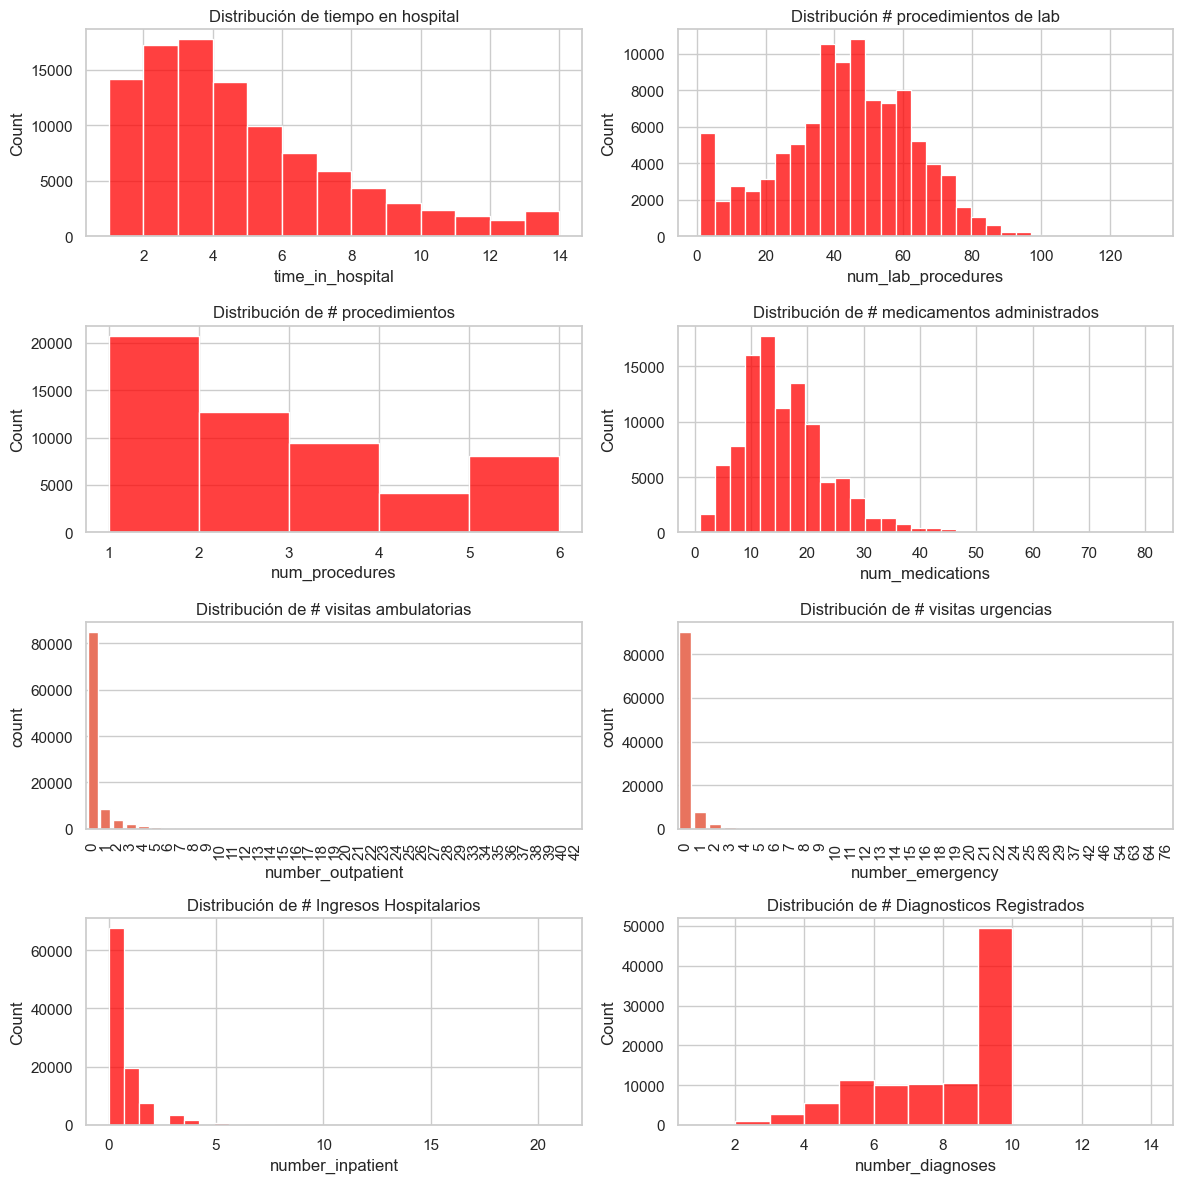

In [32]:
#DIBUJAR HISTOGRAMAS
fig, axs = plt.subplots(4, 2, figsize=(12,12))  # 2 filas, 3 columnas
axs = axs.flatten()  # Aplanamos para indexar como una lista

sns.histplot(df['time_in_hospital'], bins=range(1, 15),ax=axs[0], color='red', kde=False)
axs[0].set_title('Distribución de tiempo en hospital')

sns.histplot(df['num_lab_procedures'], bins=30,ax=axs[1], color='red', kde=False)
axs[1].set_title('Distribución # procedimientos de lab')

sns.histplot(df['num_procedures'], bins=range(1,7),ax=axs[2], color='red', kde=False)
axs[2].set_title('Distribución de # procedimientos')

sns.histplot(df['num_medications'], bins=30,ax=axs[3], color='red', kde=False)
axs[3].set_title('Distribución de # medicamentos administrados')

sns.countplot(x='number_outpatient', data=df, color='tomato', ax=axs[4])
axs[4].set_title('Distribución de # visitas ambulatorias')
axs[4].tick_params(axis='x', labelrotation=90)

sns.countplot(x='number_emergency', data=df, color='tomato', ax=axs[5])
axs[5].set_title('Distribución de # visitas urgencias')
axs[5].tick_params(axis='x', labelrotation=90)

sns.histplot(df['number_inpatient'], bins=30,ax=axs[6], color='red', kde=False)
axs[6].set_title('Distribución de # Ingresos Hospitalarios')

sns.histplot(df['number_diagnoses'], bins=range(1,15),ax=axs[7], color='red', kde=False)
axs[7].set_title('Distribución de # Diagnosticos Registrados')

plt.tight_layout()


En esta imagen se pueden observar 8 diagramas de barras correspondientes a cada variable numérica. 
* **Tiempo en el Hospital (`time_in_hospital`):** La gráfica muestra una distribución claramente sesgada a la derecha. La mayoría de los pacientes permanecen en el hospital entre 2 y 5 días, siendo 4 días la duración más frecuente. A medida que aumenta el número de días, la frecuencia disminuye significativamente, lo que indica que solo una pequeña proporción de pacientes permanece más de 10 días hospitalizado.
* **Numero de Procedimientos de Laboratorio (`num_lab_procedures`):**  La distribución es ligeramente simétrica, con una concentración de valores entre 40 y 60 procedimientos, siendo alrededor de 50 la cantidad más frecuente. Aunque hay presencia de valores cercanos a cero, su frecuencia es considerablemente menor. Esta variable refleja una variabilidad moderada y una tendencia central bien definida.
* **Número de Procedimientos Distintos(`num_procedures`):** Se observa una distribución marcadamente sesgada a la derecha, ya que la mayor parte de los pacientes recibió solo un procedimiento. La frecuencia disminuye conforme aumenta el número de procedimientos, lo que indica que pocos pacientes son sometidos a más de 3 o 4 procedimientos.
* **Número de medicamentos (`num_medications`):** La gráfica indica que la mayoría de los pacientes recibió entre 10 y 20 medicamentos, siendo esta la moda. La distribución está ligeramente sesgada a la derecha, ya que existe un número reducido de pacientes a quienes se les administraron más de 40 medicamentos, aunque en menor proporción.
* **Número de visitas ambulatorias (`number_outpatient`):** Esta variable muestra una distribución altamente sesgada a la derecha, con una fuerte concentración de pacientes que no registraron visitas ambulatorias (valor 0). Existen algunos valores atípicos con más de 20 visitas, pero representan una fracción muy pequeña de los casos.
* **Número de visitas a urgencias (`number_emergency`):** Esta variable presenta una distribución fuertemente sesgada a la derecha, donde la gran mayoría de los pacientes no tuvo ninguna visita a urgencias. Las frecuencias caen drásticamente con el aumento en el número de visitas.
* **Número de ingresos hospitalarios (`number_inpatient`):** Se evidencia también un sesgo a la derecha, ya que la mayoría de los pacientes no reportaron ingresos hospitalarios recientes. Solo una pequeña parte de la población muestra múltiples ingresos, y estos casos son poco frecuentes.
* **Número de diagnósticos registrados (`number_diagnoses` ):** Esta muestra una distribución sesgada a la izquierda, con una clara concentración de pacientes que tienen 10 diagnósticos registrados, lo que representa el valor más frecuente. Los valores más bajos son menos comunes, lo que indica que la mayoría de los pacientes presenta un número alto de diagnósticos documentados.


In [33]:
# Crear figura con 2x4 subgráficos
fig, axs = plt.subplots(2, 4, figsize=(14, 10))
axs = axs.flatten()

# Boxplots horizontales
for i, col in enumerate(columnas_numericas):
    sns.boxplot(x=df[col], ax=axs[i], color='green')
    axs[i].set_title(f'Diagrama de caja: {col}', fontsize=12)
    axs[i].set_xlabel(col)

plt.tight_layout()
plt.show()

 El diagrama de caja correspondiente a la variable valor ***Tiempo en el Hospital (`time_in_hospital`)*** muestra que la mayoría de los pacientes estuvieron hospitalizados entre 2 y 6 días, lo que indica una concentración de valores en ese rango. La mediana se sitúa aproximadamente en 4 días. Se aprecia una distribución ligeramente sesgada a la derecha, ya que la mayor parte de los datos se encuentra en los valores más bajos. Además, se identifican dos valores atípicos en 13 y 14 días, lo que sugiere que unos pocos pacientes tuvieron estancias hospitalarias significativamente más prolongadas que el promedio.

Por otra parte, el diagrama de caja correspondiente a la variable ***Numero de Procedimientos de Laboratorio (`num_lab_procedures`)*** muestra que la mayoría de los pacientes se sometieron a entre 30 y 58 procedimientos de laboratorio, con una mediana cercana a los 45 procedimientos. Además, se observan múltiples valores atípicos por encima de los 97 procedimientos aproximadamente, lo que indica que algunos pacientes fueron sometidos a una cantidad inusualmente alta de exámenes.

La gráfica de la variable ***Número de medicamentos (`num_medications`)*** indica que a la mayoría de los pacientes se les receta entre 10 a 20 medicamentos. La mediana se sitúa aproximadamente en 14 medicamentos. La distribución presenta un claro sesgo a la derecha, evidenciado por una gran cantidad de valores atípicos que superan los 35 medicamentos, alcanzando incluso cifras cercanas a 85. Esto sugiere que, aunque la mayoría de los pacientes recibió una cantidad moderada de medicamentos, existe un subconjunto que requirió tratamientos mucho más complejos, posiblemente debido a la presencia de múltiples complicaciones clínicas.

En el diagrama de caja correspondiente a la variable ***Número de diagnósticos registrados (`number_diagnoses`)*** se observa una distribución relativamente simétrica, ya que la mediana se encuentra en una posición central, alrededor de los 8 diagnósticos por paciente. La mayoría de los datos se concentran entre aproximadamente 6 y 9 diagnósticos, lo que indica una baja dispersión en la parte central de la distribución. Se identifican cuatro valores atípicos: uno inferior cercano a 1 diagnóstico, y tres superiores, a partir de los 14 diagnósticos por paciente. Estos outliers indican que, aunque la mayoría de los pacientes recibe un número moderado de diagnósticos, existen casos excepcionales con cargas diagnósticas significativamente mayores o menores. En conjunto, este gráfico sugiere que la práctica médica tiende a generar entre 6 y 9 diagnósticos por paciente, aunque en ciertos casos particulares se observan registros considerablemente más extremos.

En la parte superior derecha del conjunto de gráficos se encuentra el diagrama de caja correspondiente a la variable **Número de Procedimientos (``num_procedures``)**. Este gráfico muestra que la mayoría de los pacientes fueron sometidos entre 0 y 2 procedimientos durante su estancia hospitalaria, con una mediana en torno a 1 procedimiento. La distribución está claramente sesgada hacia la derecha, evidenciando que una proporción considerable de pacientes no recibió procedimientos adicionales, mientras que unos pocos casos alcanzan valores de hasta 6 procedimientos. Los outliers detectados representan pacientes con mayor complejidad clínica o que requirieron múltiples intervenciones, lo que, aunque poco frecuente, resulta coherente con la naturaleza de algunos tratamientos hospitalarios.

En la parte inferior izquierda se observa la gráfica correspondiente a la variable **Número de Consultas Externas (``number_outpatient``)**. La distribución de esta variable está fuertemente concentrada en cero, lo que indica que la gran mayoría de los pacientes no tuvo visitas ambulatorias recientes antes o después de su hospitalización. Sin embargo, se identifican varios valores atípicos que alcanzan hasta aproximadamente 40 consultas externas. Estos casos pueden representar pacientes con seguimiento médico continuo o tratamientos prolongados fuera del entorno hospitalario. La presencia de estos outliers refleja una alta variabilidad en la atención ambulatoria, aunque la tendencia general se centra en la ausencia de este tipo de visitas.

Por su parte, el diagrama de caja correspondiente a la variable **Número de Visitas a Urgencias (``number_emergency``)** muestra un patrón similar: la mayoría de los valores se agrupan en cero, con una mediana también igual a cero, lo que indica que la mayor parte de los pacientes no tuvo visitas a urgencias previas a la hospitalización actual. No obstante, se observan varios valores atípicos que superan las 20 e incluso 60 visitas de emergencia, representando casos excepcionales de pacientes que recurren frecuentemente a este tipo de atención. Estos valores extremos pueden asociarse a condiciones crónicas o a una mala gestión del tratamiento ambulatorio, por lo que, aunque infrecuentes, resultan clínicamente significativos.

Finalmente, el gráfico correspondiente a la variable **Número de Hospitalizaciones Previas (``number_inpatient``)** evidencia una distribución igualmente sesgada a la derecha. La mayoría de los pacientes no presenta hospitalizaciones previas (valor cero), y la mediana se mantiene también en ese punto. Sin embargo, existen múltiples valores atípicos que superan las 5 e incluso 15 hospitalizaciones, lo que indica que un pequeño grupo de pacientes ha tenido reingresos frecuentes. Estos outliers reflejan casos de alta vulnerabilidad médica o enfermedades crónicas que requieren atenciones reiteradas. Aunque numéricamente escasos, estos casos son importantes desde una perspectiva clínica, ya que podrían estar relacionados con la variable objetivo de readmisión.

#### **2.1.2. Variables Categóricas**

##### **2.1.2.1 Resumen**

In [34]:
# Crear lista con la info resumen de las variables categóricas
summary = []

for col in cat_cols:
    total = len(df)
    n_missing = df[col].isna().sum()
    n_unique = df[col].nunique(dropna=True)
    top = df[col].value_counts(dropna=True).idxmax()
    freq = df[col].value_counts(dropna=True).max()
    top_pct = (freq / total) * 100

    summary.append({
        'Variable': col,
        'Categorías únicas': n_unique,
        'Valor más frecuente': top,
        'Frecuencia': freq,
        '% del más frecuente': round(top_pct, 2),
        'Nulos': n_missing
    })

# Convertir a DataFrame para visualizar como tabla
summary_df = pd.DataFrame(summary)

# Ordenar si deseas
summary_df = summary_df.sort_values(by='Categorías únicas', ascending=False)

# Mostrar como tabla
summary_df.style.set_caption("Resumen de variables categóricas")

El resumen de las variables categóricas revela una alta proporción de valores dominantes en la mayoría de las variables. Por ejemplo, variables como glyburide-metformin, metformin-pioglitazone, glipizide-metformin, troglitazone, entre otras, presentan una distribución extremadamente desbalanceada, con un único valor que representa el 100% o casi el 100% de los casos, lo cual indica una falta de variabilidad y sugiere que podrían no aportar información útil al modelo o análisis. En contraste, variables como race, gender y readmitted muestran distribuciones más heterogéneas, con porcentajes más bajos del valor más frecuente, lo que las convierte en candidatas más informativas. Asimismo, algunas variables como medical_specialty y payer_code presentan una alta cantidad de categorías (73 y 18 respectivamente), lo cual podría introducir complejidad en el análisis y requerir estrategias como agrupación o codificación especial. Finalmente, ninguna de las variables categóricas contiene valores nulos, lo cual facilita su procesamiento posterior.

##### **2.1.2.2 Gráficos**

In [35]:
cat_ident = [
    'encounter_id', 'patient_nbr'
]
n_cols_ident = len(cat_ident)

cat_dem_ing = [
    'race', 'gender', 'age', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id',
    'time_in_hospital'
]
n_cols_dem_ing = len(cat_dem_ing)

cat_prue_proced = [
    'num_lab_procedures', 'num_procedures', 'num_medications',
    'number_outpatient', 'number_emergency', 'number_inpatient',
    'number_diagnoses'
]
n_cols_prue_proced = len(cat_prue_proced)

cat_diag_princ = [
    'diag_1', 'diag_2', 'diag_3' 
]
n_cols_diag_princ= len(cat_diag_princ)

cat_resultados_lab = [
    'max_glu_serum', 'A1Cresult'
]
n_cols_resultados_lab = len(cat_resultados_lab)

cat_meds = [
    'metformin', 'repaglinide', 'nateglinide', 'chlorpropamide',
    'glimepiride', 'acetohexamide', 'glipizide', 'glyburide',
    'tolbutamide', 'pioglitazone', 'rosiglitazone', 'acarbose',
    'miglitol', 'troglitazone', 'tolazamide', 'examide',
    'citoglipton', 'insulin', 'glyburide-metformin',
    'glipizide-metformin', 'glimepiride-pioglitazone',
    'metformin-rosiglitazone', 'metformin-pioglitazone'
]
n_cols_meds = len(cat_meds)

cat_control_tratamiento = [
    'change', 'diabetesMed'
]
n_cols_control_tratamiento = len(cat_control_tratamiento)

cat_objetivo = [
    'readmitted'
]
n_cols_objetivo = len(cat_objetivo)


In [36]:
def graficar_cat(n_cols, cat, figura_num=1, titulo_general=None, palette='Set2'):
    # Número de columnas fijas
    cols = 3
    rows = math.ceil(n_cols / cols)

    # Crear figura
    fig, axs = plt.subplots(rows, cols, figsize=(cols*6, rows*4))
    axs = axs.flatten()

    for i, col in enumerate(cat):
        ax = axs[i]
        n_cat = df[col].nunique()

        if n_cat <= 10:
            orden = df[col].value_counts().sort_values(ascending=False).index
            sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
        else:
            top_10 = df[col].value_counts().nlargest(10)
            categorias_ordenadas = top_10.index
            frecuencias = top_10.values
            sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)

        ax.set_title(f'{col} ({n_cat} cat.)', fontsize=10)
        ax.set_xlabel('')
        ax.set_ylabel('Frecuencia')
        ax.tick_params(axis='x', rotation=45)

    # Eliminar ejes vacíos
    for j in range(i + 1, len(axs)):
        fig.delaxes(axs[j])

    # Ajustar el espacio automáticamente
    plt.tight_layout(rect=[0, 0.05, 1, 0.93])  # deja espacio para el título y el pie

    # Título general centrado
    if titulo_general:
        fig.text(0.5, 0.96, titulo_general, ha='center', fontsize=16, weight='bold')

    # Pie de figura centrado
    fig.text(0.5, 0.02, f'Figura {figura_num}. {titulo_general}', ha='center', fontsize=12)
    

    plt.show()


######  **2.1.2.2.1 Distribución de Variables Demográficas y de Ingreso**

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Tem

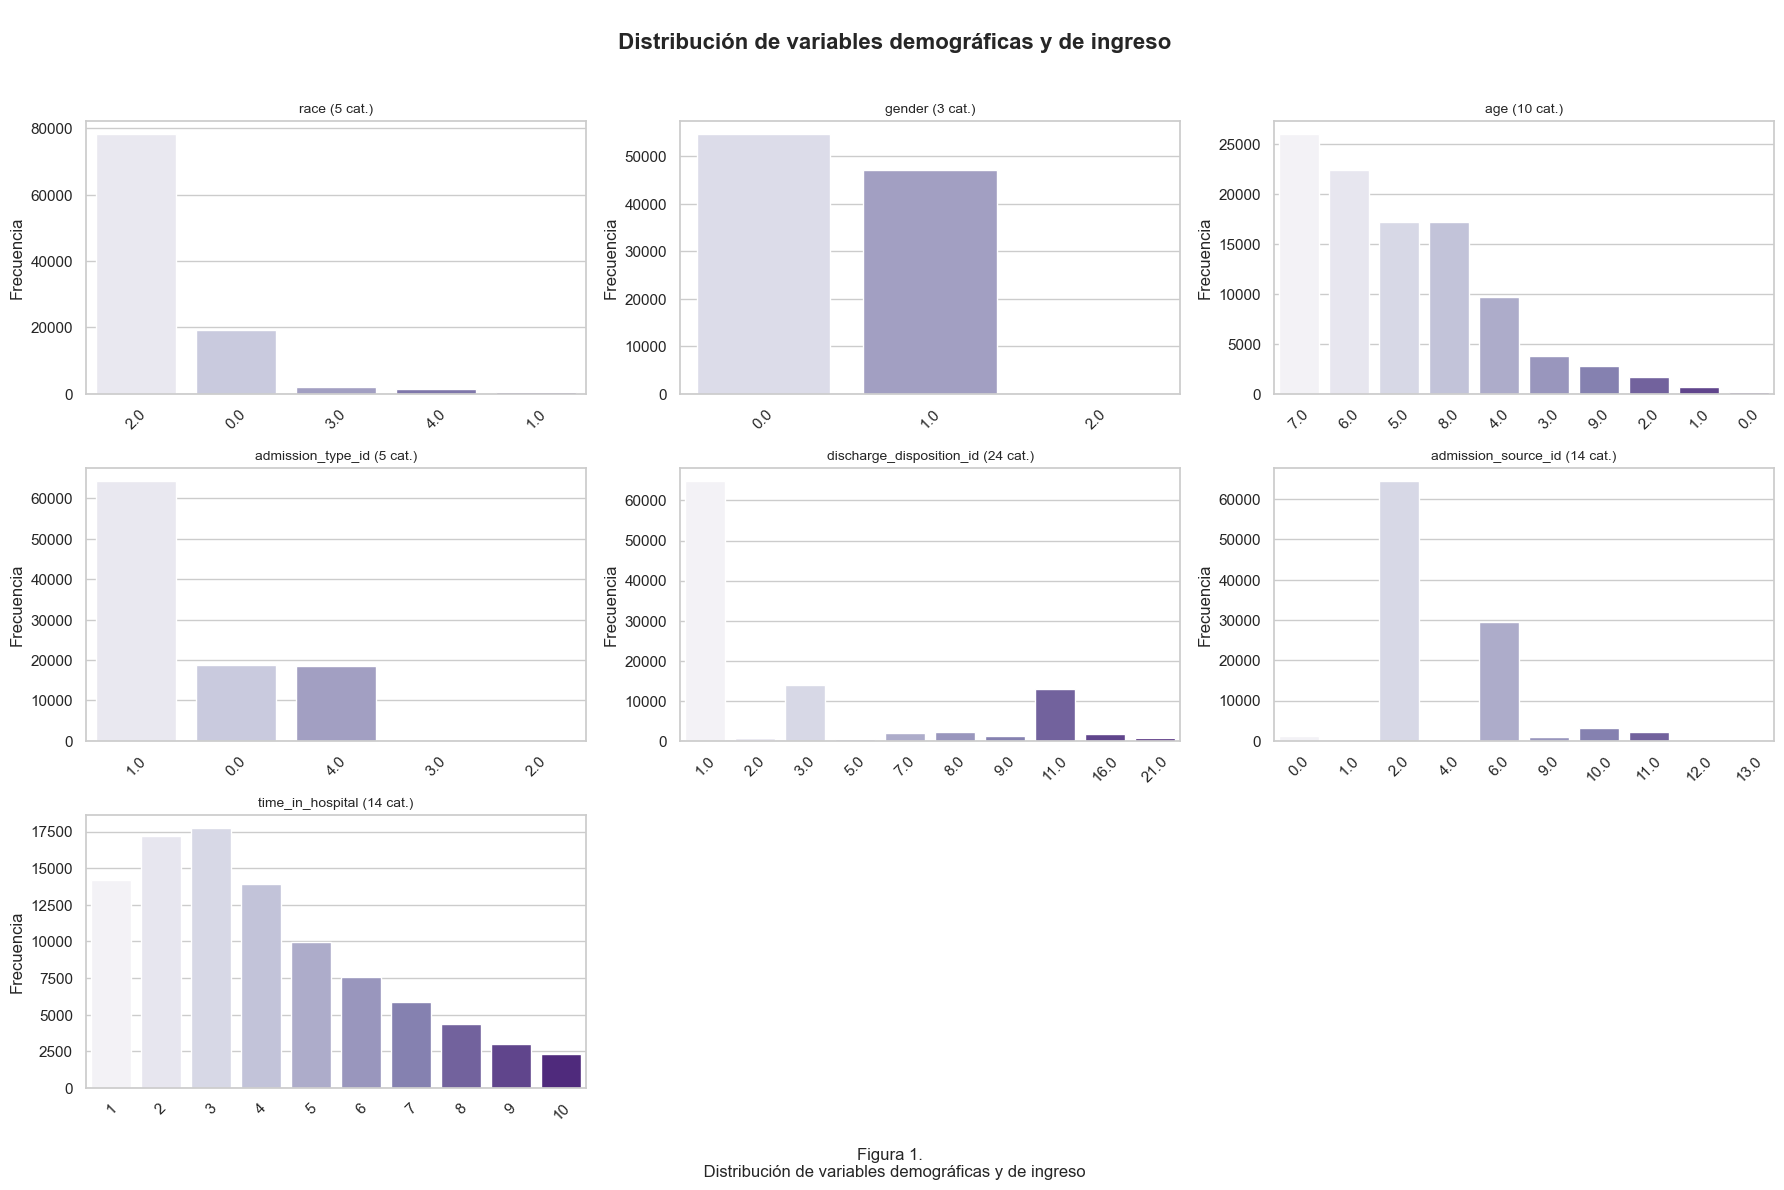

In [37]:
graficar_cat(n_cols_dem_ing, cat_dem_ing, figura_num=1,
             titulo_general='\n Distribución de variables demográficas y de ingreso',
             palette='Purples')  # o 'Blues', 'coolwarm', etc.

La figura presenta la distribución de varias variables categóricas relacionadas con las características demográficas de los pacientes y su ingreso hospitalario.

- **Raza (`race`)**:  
  Se observa que la mayoría de los pacientes pertenecen a la categoría **2**, correspondiente a **Caucasian (caucásicos)**. Las demás categorías, como **AfricanAmerican**, **Hispanic**, **Asian** y **Other**, muestran una frecuencia considerablemente menor. Esto indica que la población del estudio está compuesta mayoritariamente por pacientes de origen caucásico, lo que puede influir en la representatividad del análisis.

- **Género (`gender`)**:  
  La variable muestra una ligera mayoría de la categoría **0 (Female)** frente a la **1 (Male)**, reflejando una leve predominancia de mujeres en la muestra. La categoría **2 (Unknown/Invalid)** tiene una presencia mínima, lo cual sugiere una buena calidad del registro en este campo.

- **Edad (`age`)**:  
  Se identifica una mayor concentración de pacientes en las categorías **5 a 7**, que representan los grupos de edad entre **50 y 80 años**. Este patrón es coherente con el perfil clínico de enfermedades como la **diabetes tipo 2**, que afecta principalmente a adultos mayores. La frecuencia disminuye en los extremos inferiores y superiores de la edad.

- **Tipo de ingreso (`admission_type_id`)**:  
  Predomina la categoría **1 (Emergency)**, lo que indica que la mayoría de los pacientes ingresaron al hospital por situaciones **urgentes o no programadas**. En contraste, los ingresos de tipo **Elective (0)** y **Urgent (4)** son menos frecuentes, lo que refleja la naturaleza crítica de la atención hospitalaria en este conjunto de datos.

- **Condición de alta (`discharge_disposition_id`)**:  
  Aunque existen numerosas categorías, la más común es la **1 (Discharged to home)**, lo que implica que la mayoría de los pacientes fueron dados de alta a su domicilio tras el tratamiento. Otras categorías como **3 (Transfer to another facility)** o **11 (Expired)** aparecen con menor frecuencia, pero son relevantes para el análisis del desenlace clínico.

- **Fuente de ingreso (`admission_source_id`)**:  
  La categoría más representativa es la **2 (Emergency Room)**, confirmando que la mayoría de los ingresos provienen de la sala de urgencias. Esto es consistente con el predominio de ingresos de tipo **Emergency** observado en la variable `admission_type_id`, lo que refuerza la coherencia interna del dataset.

- **Tiempo en el hospital (`time_in_hospital`)**:  
  La distribución muestra una mayor frecuencia en las categorías entre **1 y 4 días**, con una disminución progresiva en estancias más largas. Esto sugiere que la mayoría de los pacientes permanecen hospitalizados por periodos **cortos a moderados**, lo que puede asociarse a casos clínicos controlados o tratamientos ambulatorios de corta duración.


###### **2.1.2.2.2 Distribución de Pruebas, Procedimientos y Medicamentos**

In [38]:
graficar_cat(n_cols_prue_proced, cat_prue_proced, figura_num=2,
             titulo_general='\n Distribución de pruebas, procedimientos y medicamentos',
             palette='Blues')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)
C:\Users\Usuario\A

La figura muestra la distribución de diferentes variables relacionadas con los procedimientos médicos, las pruebas realizadas y el número de medicamentos administrados durante las hospitalizaciones.

- **Número de procedimientos de laboratorio (`num_lab_procedures`)**:  
  Esta variable tiene muchas categorías (118), pero se observa que hay una concentración importante en valores entre 40 y 47 procedimientos por paciente. Es decir, la mayoría de los pacientes tuvieron una cantidad intermedia de pruebas de laboratorio, lo que sugiere un nivel de monitoreo moderado durante la hospitalización.

- **Número de procedimientos (`num_procedures`)**:  
  En este caso, la mayoría de los pacientes tuvo **cero o un procedimiento** médico. Las frecuencias disminuyen progresivamente a medida que aumenta el número de procedimientos, lo que indica que la intervención médica directa no fue tan alta en la mayoría de los casos.

- **Número de medicamentos (`num_medications`)**:  
  Hay una clara tendencia a la alta cantidad de medicamentos administrados. Las categorías más frecuentes están entre **10 y 18 medicamentos**, lo que podría indicar tratamientos complejos o presencia de múltiples condiciones médicas.

- **Consultas externas (`number_outpatient`)**:  
  La mayoría de los pacientes no tuvo consultas externas previas a la hospitalización (valor 0). Solo una pequeña proporción tuvo una o más visitas ambulatorias, lo que sugiere que muchos ingresos fueron inesperados o sin seguimiento ambulatorio reciente.

- **Visitas a emergencias (`number_emergency`)**:  
  Al igual que en el caso anterior, la mayoría de los pacientes no tuvo visitas previas a emergencias antes de ser hospitalizados. Esto puede reforzar la idea de que muchos ingresos fueron por primera atención de una complicación aguda.

- **Consultas internas previas (`number_inpatient`)**:  
  Se observa que la mayoría no tuvo hospitalizaciones anteriores (valor 0), aunque existe una pequeña proporción que ha sido hospitalizada previamente en múltiples ocasiones, lo que puede reflejar casos más crónicos o severos.

- **Cantidad de diagnósticos (`number_diagnoses`)**:  
  La mayoría de los pacientes tiene registrados **nueve diagnósticos**, que es el valor máximo permitido por la base de datos. Esto indica que muchos pacientes presentan **múltiples condiciones de salud**, lo que puede reflejar la complejidad clínica del grupo.

###### **2.1.2.2.3 Distribución de Diagnósticos**

In [39]:
graficar_cat(n_cols_diag_princ, cat_diag_princ, figura_num=3,
             titulo_general='\n Diagnósticos principales y secundarios',
             palette='Greens')

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=categorias_ordenadas, y=frecuencias, ax=ax, palette=palette)


Esta figura muestra la distribución de los diagnósticos principales (`diag_1`) y secundarios (`diag_2`, `diag_3`) registrados para cada paciente. Las categorías representan grupos de enfermedades, basados en los códigos ICD-9 agrupados por rangos.

- **Diagnóstico principal (`diag_1`)**:  
  La categoría más frecuente es la **2.0**, relacionada con enfermedades del sistema circulatorio. Le sigue la categoría **14.0**, que representa los diagnósticos de diabetes (por ejemplo, códigos 250.xx). Esta combinación muestra que muchos pacientes ingresan al hospital con complicaciones cardíacas o directamente por complicaciones derivadas de la diabetes.

- **Segundo diagnóstico (`diag_2`)**:  
  De nuevo, la categoría **2.0** sobresale por mucho, indicando que muchas personas presentan enfermedades cardiovasculares como condición secundaria. Le siguen las categorías **3.0** (enfermedades del sistema respiratorio) y **14.0** (diabetes), con frecuencias similares. Esto refleja que, en pacientes con múltiples condiciones, es muy común ver esta combinación de enfermedades circulatorias, respiratorias y metabólicas.

- **Tercer diagnóstico (`diag_3`)**:  
  En este caso, la categoría **2.0** continúa siendo la más común, y la **3.0** le sigue con una frecuencia notable —un poco más de la mitad de la que tiene la categoría 2.0. Esta tendencia refuerza la idea de que las enfermedades del corazón y pulmón son condiciones crónicas recurrentes en pacientes hospitalizados, muchas veces en conjunto con la diabetes.

###### **2.1.2.2.4 Distribución de Resultados de Laboratorio**

In [40]:
graficar_cat(n_cols_resultados_lab, cat_resultados_lab, figura_num=4,
             titulo_general='\n Resultados de laboratorio',
             palette='Oranges')


C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)


Esta figura muestra la distribución de dos variables relacionadas con exámenes clínicos importantes en el control de la diabetes: `max_glu_serum` (nivel máximo de glucosa en suero) y `A1Cresult` (resultado del examen de hemoglobina glicosilada).

- **Nivel máximo de glucosa en suero (`max_glu_serum`)**:  
  La mayoría de los registros se encuentran en la categoría **3.0**, que corresponde a **"No se realizó el test"**. Esto indica que para la gran mayoría de pacientes no se midió el valor máximo de glucosa durante su estancia hospitalaria. Las demás categorías (0.0, 1.0, 2.0) tienen frecuencias muy bajas, lo que sugiere que cuando sí se hace la prueba, es en muy pocos casos.

- **Resultado del examen A1C (`A1Cresult`)**:  
  Al igual que en la variable anterior, la categoría más frecuente es la **3.0**, lo que también significa que **no se realizó el test de hemoglobina glicosilada**. Las otras tres categorías (0.0: "normal", 1.0: ">7", 2.0: ">8") están presentes pero con frecuencias mucho menores. Esto puede implicar que el seguimiento a largo plazo del control glucémico no se hace de manera sistemática en los pacientes hospitalizados.


###### **2.1.2.2.5 Distribución de Medicamentos Administrados Durante la Estancia**

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Tem

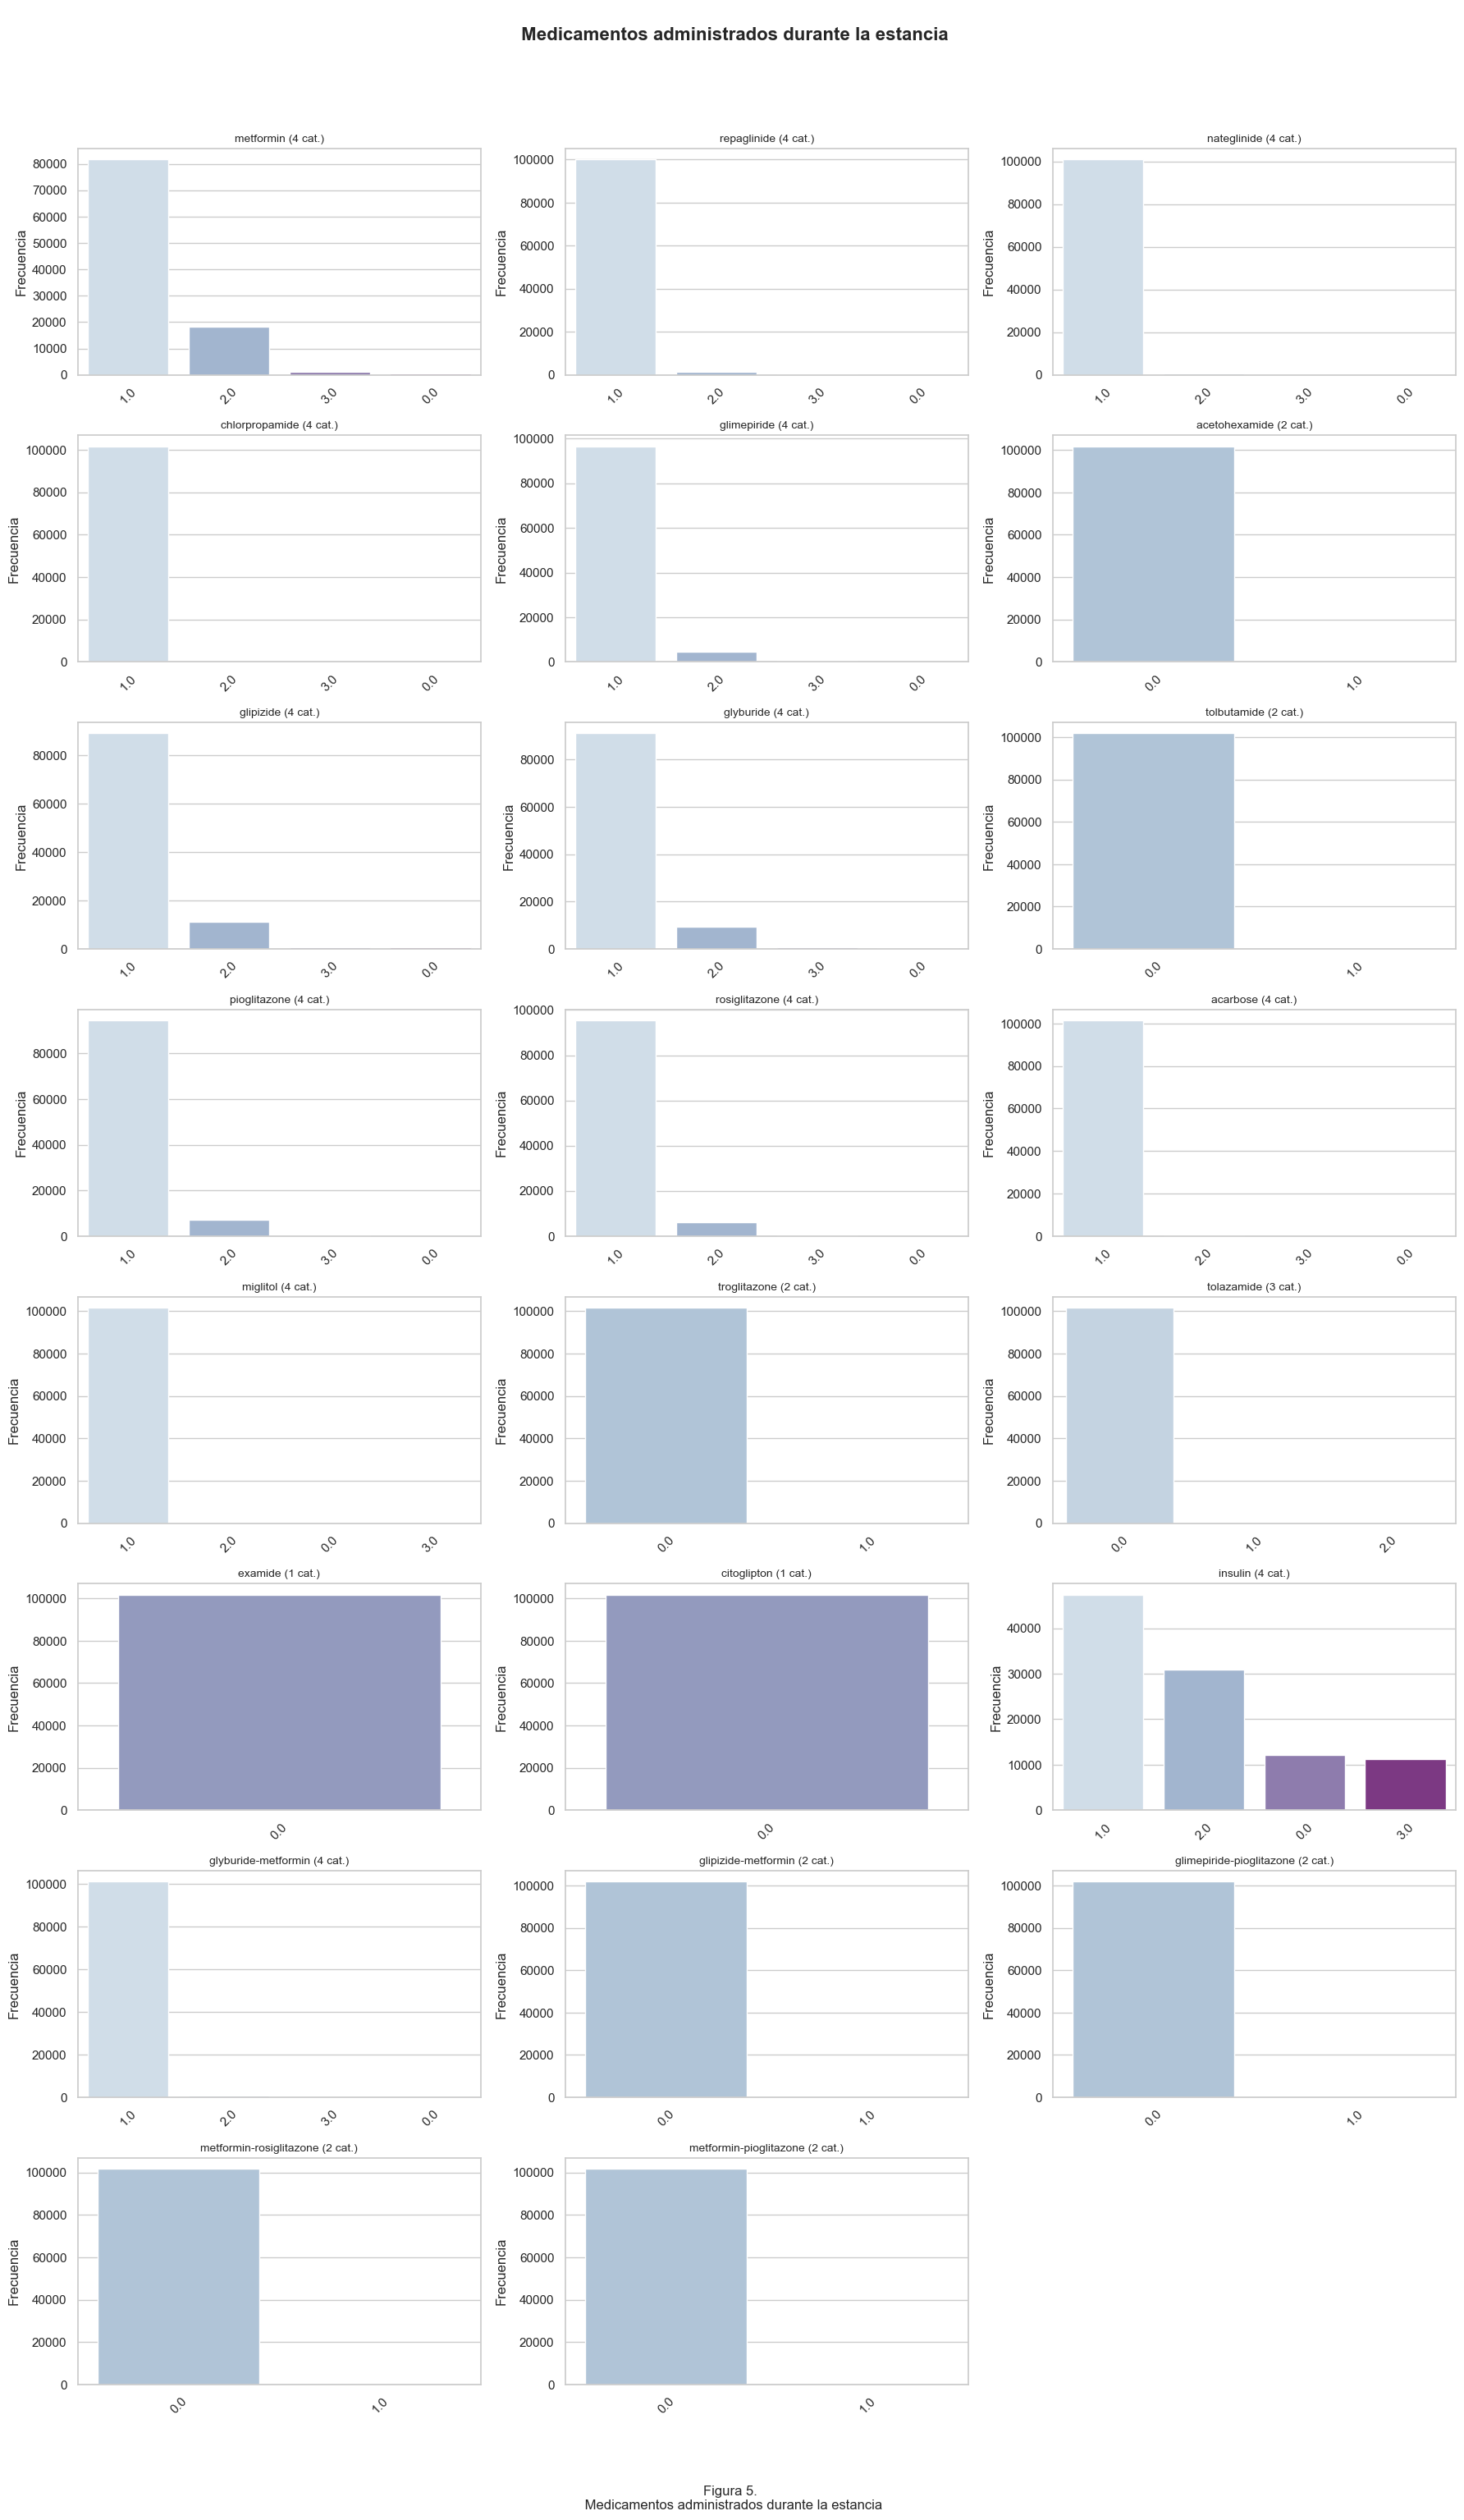

In [41]:
graficar_cat(n_cols_meds, cat_meds, figura_num=5,
             titulo_general='\n Medicamentos administrados durante la estancia',
             palette='BuPu')

Esta figura presenta la distribución de diferentes medicamentos utilizados en pacientes hospitalizados con diagnóstico de diabetes. 

- En general, la mayoría de los medicamentos individuales (como `metformin`, `glimepiride`, `glyburide`, `pioglitazone`, entre otros) tienen como categoría más común el valor **1.0**, lo que indica que **la medicación no cambió durante la estancia**. Es decir, los pacientes que ya estaban tomando estos medicamentos continuaron con ellos.

- Las categorías **2.0** (medicación añadida) y **3.0** (medicación discontinuada) aparecen con menor frecuencia. En la mayoría de los casos, la categoría **0.0** (medicación nunca utilizada) tiene una baja frecuencia, **excepto en medicamentos poco comunes**, como `acetohexamide`, `tolazamide` o combinaciones poco frecuentes.

- En los **medicamentos combinados** (como `glyburide-metformin`, `glipizide-metformin`, `metformin-pioglitazone`), se observa que la mayoría de los pacientes **no recibieron estas combinaciones durante la hospitalización**. Esto puede deberse a que estas terapias son más comunes en tratamientos ambulatorios que en contextos agudos.

- Una excepción interesante es la **insulina**, donde las frecuencias están distribuidas entre todas las categorías. Esto indica que **sí hubo ajustes importantes en su administración**, probablemente en respuesta a las necesidades clínicas inmediatas de los pacientes hospitalizados.


###### **2.1.2.2.6 Distribución Control del Tratamiento Para la Diabetes**

In [42]:
graficar_cat(n_cols_control_tratamiento, cat_control_tratamiento, figura_num=6,
             titulo_general='\n Control del tratamiento para la diabetes',
             palette='coolwarm')


C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)



Esta figura presenta la distribución de dos variables relacionadas con el control del tratamiento de pacientes hospitalizados con diagnóstico de diabetes.

- En el gráfico izquierdo, correspondiente a la variable `change`, se observa que la mayoría de los pacientes presentan un valor de **1.0**, lo que indica que **hubo un cambio en la medicación durante la hospitalización**. Este comportamiento sugiere que, en muchos casos, el tratamiento fue ajustado, probablemente en respuesta a evaluaciones médicas o complicaciones agudas. No obstante, una cantidad considerable de pacientes también se mantuvo con su tratamiento sin cambios (`0.0`), lo que podría reflejar condiciones estables o seguimiento de un protocolo ya establecido.

- En el gráfico derecho, correspondiente a la variable `diabetesMed`, se destaca que la mayoría de los pacientes tienen un valor de **1.0**, lo que significa que **recibieron medicación para la diabetes durante su estancia hospitalaria**. En contraste, una proporción menor de pacientes (`0.0`) no recibió medicación, lo cual puede deberse a múltiples factores, como estadías cortas, control dietético, o decisiones clínicas específicas. La predominancia del uso de medicamentos refleja la importancia del tratamiento farmacológico en el manejo hospitalario de la diabetes.

Ambas variables reflejan la dinámica del tratamiento médico en contextos hospitalarios, evidenciando tanto la alta tasa de intervención como la adaptación del manejo clínico según las condiciones del paciente.

###### **2.1.2.2.7 Distribución de la variable objetivo (readmisión)**

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\1968926968.py:16: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=col, data=df, order=orden, ax=ax, palette=palette)


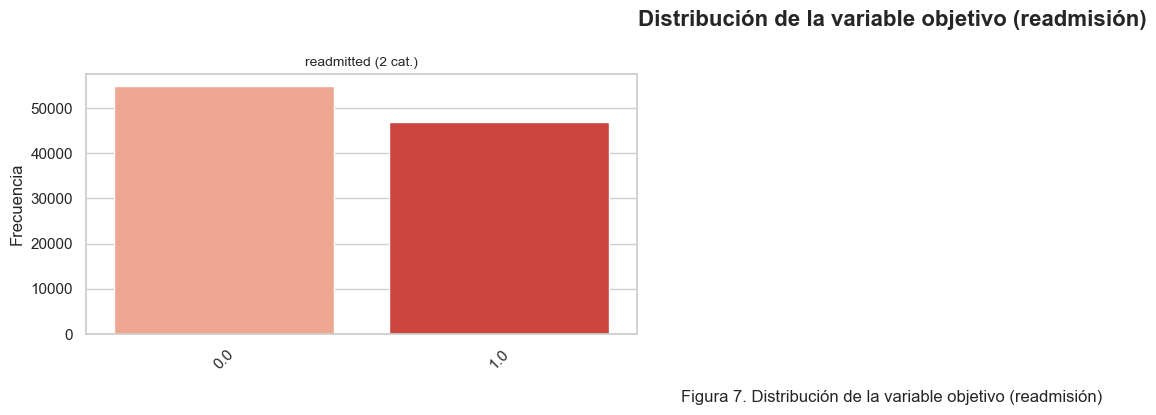

In [43]:
graficar_cat(n_cols_objetivo, cat_objetivo, figura_num=7,
             titulo_general='Distribución de la variable objetivo (readmisión)',
             palette='Reds')

El gráfico revela que la mayoría de los pacientes no fueron readmitidos (`2.0`), con una frecuencia superior a 50.000 casos. En segundo lugar se encuentran los pacientes que sí fueron readmitidos, pero después de 30 días (`1.0`), y finalmente, con una frecuencia mucho menor, los pacientes que fueron readmitidos antes de 30 días (`0.0`).

### **2.2. Análisis Bivariado:**

#### **2.2.1. Variables Numéricas:** 

In [44]:
sns.pairplot(df[columnas_numericas], plot_kws={'alpha':0.4, 's':15})

Como análisis general, en la matriz de dispersión no se aprecian relaciones lineales claras o fuertes entre la mayoría de las variables numéricas, lo que coincide con lo observado en la matriz de correlación, donde no se identificaron valores de 𝑟^2 elevados. En su lugar, predominan correlaciones débiles o negativas, lo que sugiere que estas variables, de forma individual, podrían tener una capacidad limitada para explicar la variabilidad de otras dentro del conjunto de datos.

#### **2.3.2. Variables Categóricas**

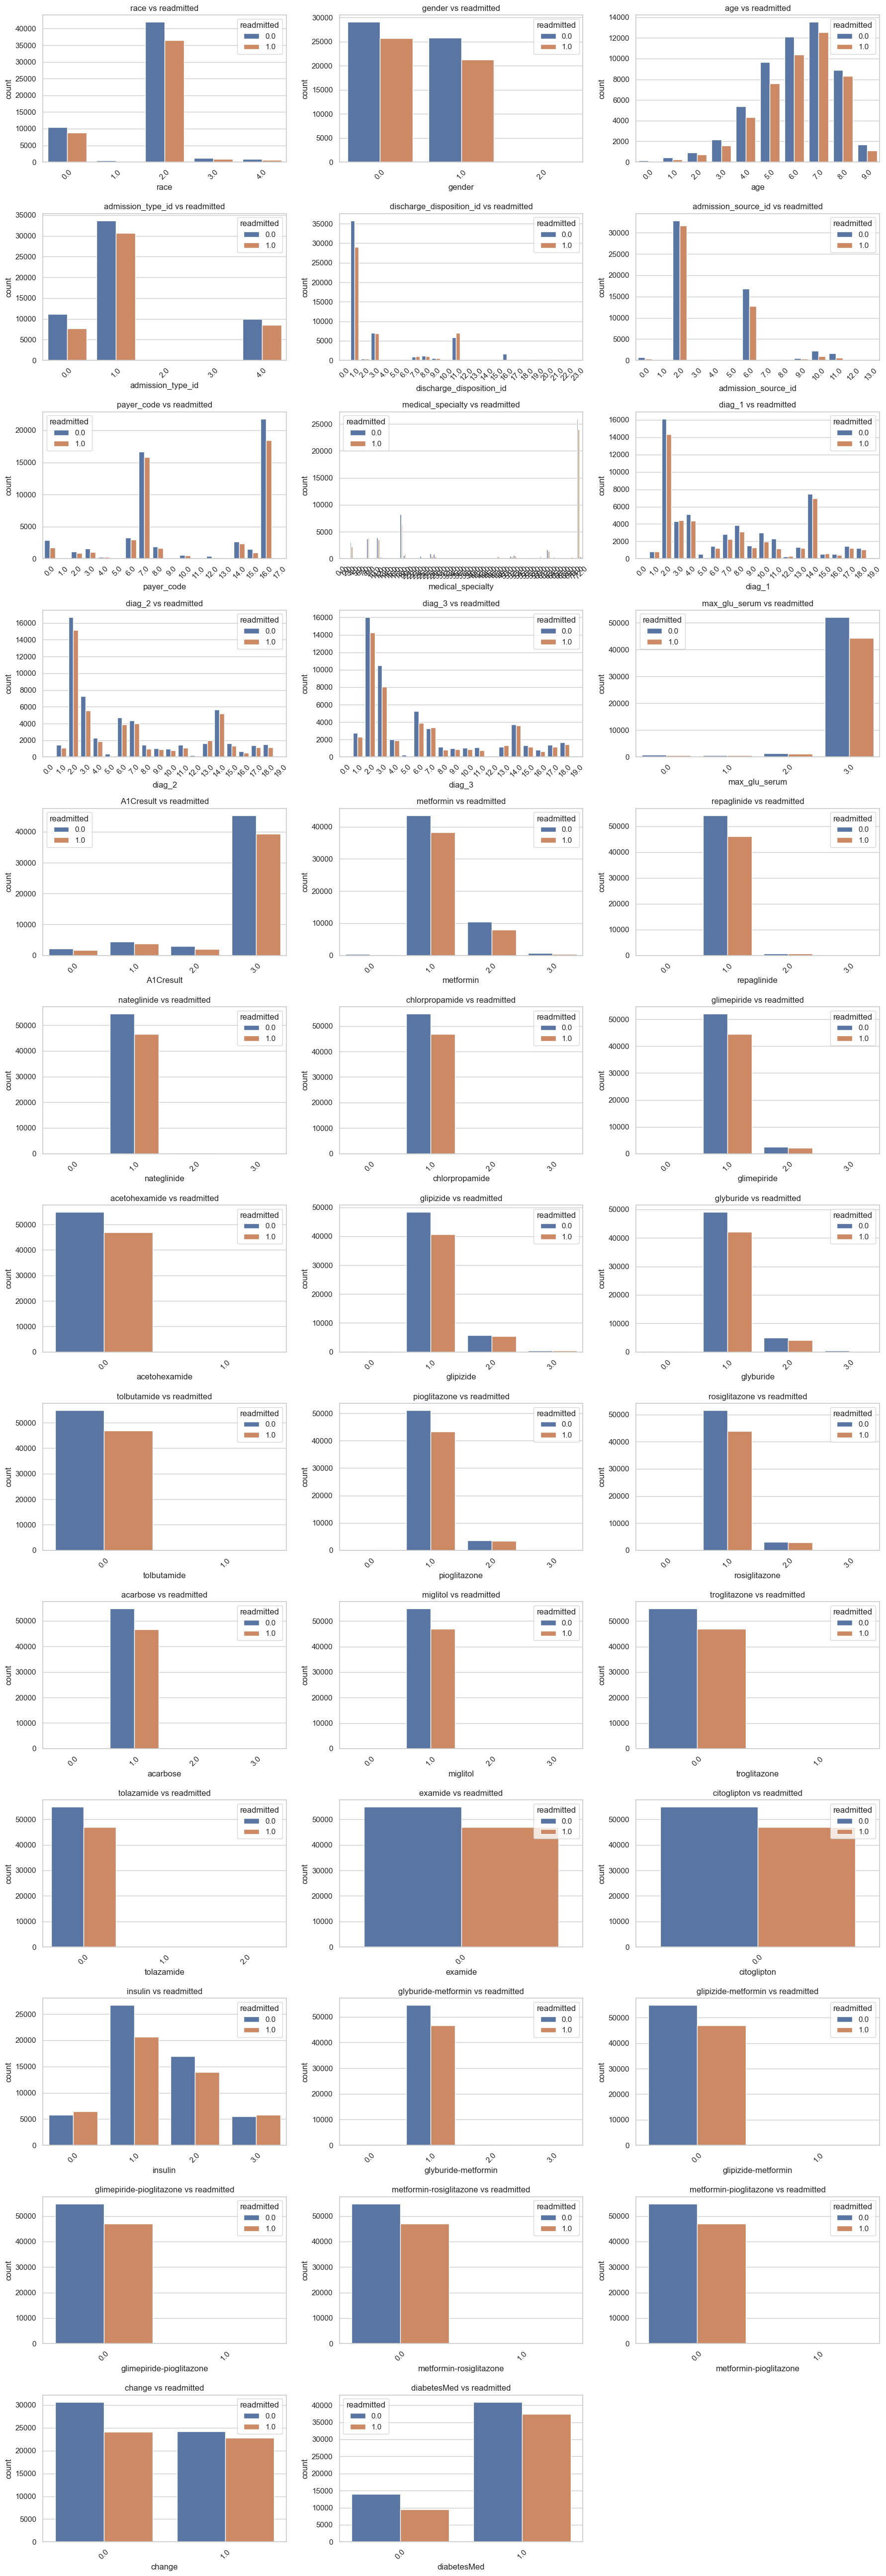

In [45]:
# Variables categóricas (excepto 'readmitted')
categorical_vars = df.select_dtypes(include=['object','category']).columns.drop('readmitted')

# Definir tamaño de la cuadrícula
n_cols = 3  # número de gráficos por fila
n_rows = math.ceil(len(categorical_vars) / n_cols)  # filas necesarias

# Crear la figura
fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols*6, n_rows*4))
axes = axes.flatten()  # para iterar fácilmente

# Graficar cada variable en un subplot
for i, col in enumerate(categorical_vars):
    sns.countplot(x=col, hue='readmitted', data=df, ax=axes[i])
    axes[i].set_title(f"{col} vs readmitted")
    axes[i].tick_params(axis='x', rotation=45)

# Eliminar ejes vacíos si sobran
for j in range(i+1, len(axes)): 
    fig.delaxes(axes[j])    
plt.tight_layout()
plt.show()

De forma general, en estas gráficas se observa que, para la mayoría de las variables categóricas, una gran proporción de los pacientes corresponde a aquellos que no han sido readmitidos en el hospital. Este patrón se repite de manera consistente, independientemente de la variable analizada, lo que sugiere que la clase de no readmisión es predominante en el conjunto de datos. Si bien algunas variables como race, gender o age muestran una distribución más equilibrada entre sus categorías internas, la tendencia general sigue favoreciendo a los pacientes sin readmisión.

En conjunto, no se identifican patrones categóricos evidentes que permitan diferenciar de forma clara a los pacientes según su estado de readmisión únicamente a partir de estas variables. Sin embargo, se detecta que ciertas variables con un mayor número de categorías —como medical_specialty o payer_code— podrían contener información útil si se agrupan o transforman para reducir la dispersión y aumentar su representatividad. Asimismo, variables relacionadas con tratamientos o medicación, aunque concentradas en pocas categorías, podrían aportar valor predictivo al combinarse con otras variables en un modelo multivariado, ya que podrían reflejar prácticas clínicas o perfiles de pacientes asociados con un mayor riesgo de readmisión.

#### **2.3. Análisis multivariado**

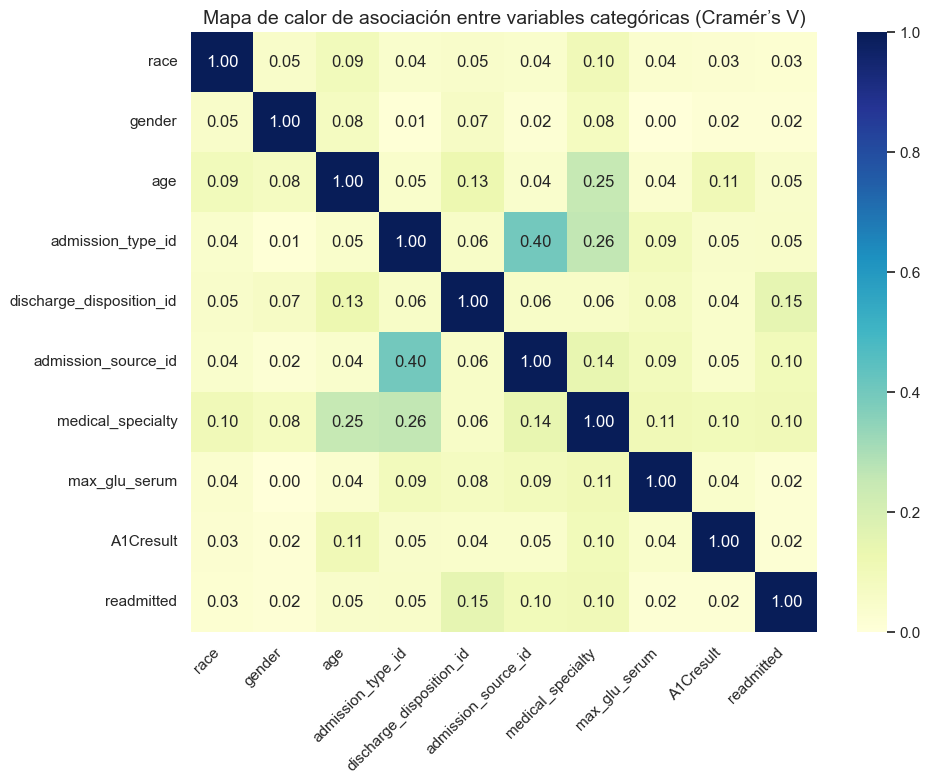

In [46]:
# --- Función para calcular Cramer's V ---
def cramers_v(x, y):
    """
    Calcula el coeficiente de asociación de Cramér's V entre dos variables categóricas.
    """
    confusion_matrix = pd.crosstab(x, y)
    chi2 = chi2_contingency(confusion_matrix, correction=False)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2 / n
    r, k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1)) / (n-1))
    rcorr = r - ((r-1)**2) / (n-1)
    kcorr = k - ((k-1)**2) / (n-1)
    return np.sqrt(phi2corr / min((kcorr-1), (rcorr-1)))

# --- Selección de variables categóricas ---
# (Puedes ajustar esta lista según tu dataset)
cat_vars = [
    'race', 'gender', 'age', 'admission_type_id',
    'discharge_disposition_id', 'admission_source_id',
    'medical_specialty', 'max_glu_serum', 'A1Cresult', 'readmitted'
]

# Filtramos solo las columnas que existen en el DataFrame
cat_vars = [c for c in cat_vars if c in df.columns]

# --- Calcular matriz de asociaciones ---
assoc_matrix = pd.DataFrame(
    np.zeros((len(cat_vars), len(cat_vars))),
    index=cat_vars,
    columns=cat_vars
)

for var1 in cat_vars:
    for var2 in cat_vars:
        assoc_matrix.loc[var1, var2] = cramers_v(df[var1], df[var2])

# --- Graficar el mapa de calor ---
plt.figure(figsize=(10, 8))
sns.heatmap(assoc_matrix, annot=True, cmap='YlGnBu', fmt=".2f")
plt.title("Mapa de calor de asociación entre variables categóricas (Cramér’s V)", fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


El mapa de calor muestra el nivel de asociación entre las variables categóricas del conjunto de datos mediante el coeficiente de Cramér’s V. En general, se observa que la mayoría de las asociaciones presentan valores bajos (menores a 0.25), lo que indica una relación débil entre las variables categóricas analizadas. Las celdas más oscuras representan asociaciones más fuertes, siendo el caso más notable el vínculo entre las variables *admission_type_id* y *admission_source_id*, con un valor de 0.40, lo que sugiere una relación moderada entre el tipo y la fuente de admisión del paciente. También se aprecia una ligera relación entre *age* y *medical_specialty* (0.25), lo que podría reflejar que ciertas especialidades médicas atienden con mayor frecuencia a grupos etarios específicos. En contraste, variables como *race*, *gender*, *max_glu_serum* y *A1Cresult* muestran asociaciones prácticamente nulas con el resto, lo que implica que no existe dependencia relevante entre ellas. En conjunto, estos resultados indican que las variables categóricas son en su mayoría independientes, lo que es favorable para los análisis posteriores, ya que reduce el riesgo de redundancia o multicolinealidad entre factores cualitativos.


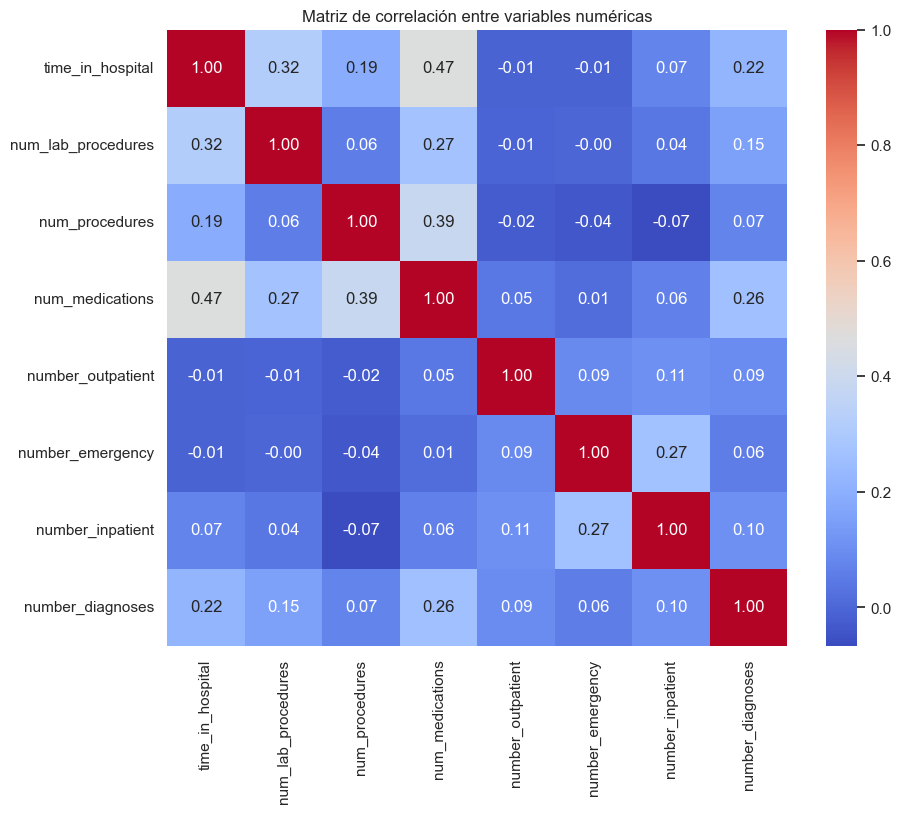

In [47]:
plt.figure(figsize=(10, 8))
sns.heatmap(df[columnas_numericas].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Matriz de correlación entre variables numéricas')
plt.show()

La matriz de correlación indica que no existen relaciones lineales fuertes entre las variables numéricas del conjunto de datos. La mayoría de los coeficientes de correlación se sitúan cerca de cero, lo que sugiere una asociación débil o inexistente entre las variables. La correlación más alta observada es de 0.47 entre `time_in_hospital` y `num_medications`, lo cual representa una relación moderada. También se evidencia una correlación leve de 0.39 entre `num_procedures` y `num_medications`. En general, los valores sugieren que las variables numéricas analizadas tienden a comportarse de manera independiente unas de otras.

C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\3720977784.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


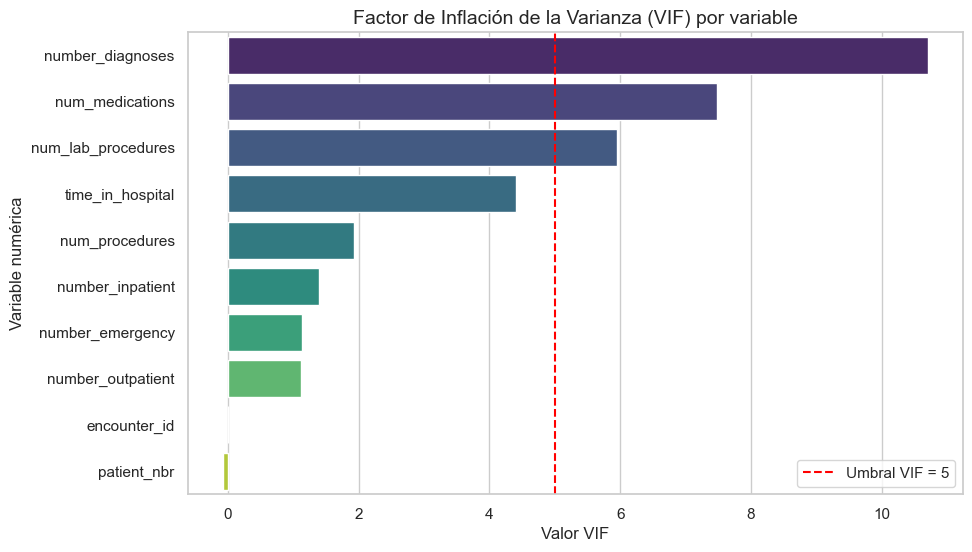

In [48]:
df_num = df.select_dtypes(include=[np.number])
vif_data = pd.DataFrame()
vif_data["Variable"] = df_num.columns
vif_data["VIF"] = [variance_inflation_factor(df_num.values, i)
                   for i in range(df_num.shape[1])]

# Gráfico de barras del VIF
plt.figure(figsize=(10,6))
sns.barplot(
    data=vif_data.sort_values(by="VIF", ascending=False),
    x="VIF",
    y="Variable",
    palette="viridis"
)
plt.title("Factor de Inflación de la Varianza (VIF) por variable", fontsize=14)
plt.xlabel("Valor VIF")
plt.ylabel("Variable numérica")
plt.axvline(x=5, color="red", linestyle="--", label="Umbral VIF = 5")
plt.legend()
plt.show()



El gráfico presenta los valores del Factor de Inflación de la Varianza (VIF) para las variables numéricas del conjunto de datos, con el objetivo de evaluar la presencia de colinealidad entre ellas. En general, se observa que la mayoría de las variables presentan valores por debajo del umbral de 5, lo que indica que no existe una colinealidad problemática. Sin embargo, las variables *number_diagnoses*, *num_medications* y *num_lab_procedures* muestran los valores más altos de VIF, siendo la primera la más elevada, superando el umbral establecido. Esto sugiere que estas variables están fuertemente relacionadas entre sí o con alguna otra variable del modelo, lo cual podría generar redundancia en el análisis. En contraste, variables como *patient_nbr* y *encounter_id* presentan valores muy bajos, lo que significa que son prácticamente independientes de las demás. En conclusión, aunque la mayoría de las variables numéricas no presentan problemas de colinealidad, se recomienda revisar las que superan el valor de referencia, ya que podrían afectar la estabilidad de los modelos estadísticos o predictivos.


## **3. Evidencia Análitica:**

#### **3.1. Prueba sobre la normalidad de los datos**

In [49]:
# Seleccionar solo las variables numéricas
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Lista para guardar resultados
resultados = []

# Aplicar la prueba K-S a cada variable numérica
for col in numeric_cols:
    data = df[col].dropna()
    
    if len(data) > 0:
        # Estandarizar los datos (requerido por KS)
        data_std = (data - data.mean()) / data.std(ddof=0)
        
        # Prueba Kolmogorov–Smirnov con distribución normal teórica
        stat, p = kstest(data_std, 'norm')
        
        # Conclusión
        conclusion = "✅ Normal" if p > 0.05 else "⚠️ No normal"
        resultados.append([col, stat, p, conclusion])
    else:
        resultados.append([col, None, None, "Sin datos"])

# Crear DataFrame con resultados
df_ks = pd.DataFrame(resultados, columns=["Variable", "Estadístico", "p-value", "Conclusión"])

# Ordenar por p-value
df_ks = df_ks.sort_values("p-value", ascending=True).reset_index(drop=True)

# Mostrar resultados
print(df_ks)

             Variable  Estadístico        p-value    Conclusión
0        encounter_id     0.080462   0.000000e+00  ⚠️ No normal
1         patient_nbr     0.099754   0.000000e+00  ⚠️ No normal
2    time_in_hospital     0.172935   0.000000e+00  ⚠️ No normal
3      num_procedures     0.242314   0.000000e+00  ⚠️ No normal
4   number_outpatient     0.450166   0.000000e+00  ⚠️ No normal
5     num_medications     0.097293   0.000000e+00  ⚠️ No normal
6    number_emergency     0.472334   0.000000e+00  ⚠️ No normal
7    number_inpatient     0.357179   0.000000e+00  ⚠️ No normal
8    number_diagnoses     0.279973   0.000000e+00  ⚠️ No normal
9  num_lab_procedures     0.047394  4.342067e-199  ⚠️ No normal


In [50]:
def matriz_qqplot(df, num_vars=None, ncols=3):
    # Detectar variables numéricas automáticamente si no se pasan
    if num_vars is None:
        num_vars = df.select_dtypes(include=[np.number]).columns.tolist()

    n = len(num_vars)
    nrows = int(np.ceil(n / ncols))

    # Crear figura general
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5*ncols, 4*nrows))
    axes = axes.flatten()

    for i, var in enumerate(num_vars):
        sm.qqplot(df[var].dropna(), line='s', ax=axes[i])
        axes[i].set_title(f"QQ Plot - {var}", fontsize=11)

    # Eliminar subplots vacíos
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Matriz de QQ Plots para variables numéricas", fontsize=15, y=1.02)
    plt.tight_layout()
    plt.show()


In [51]:
matriz_qqplot(df, num_vars=numeric_cols, ncols=3)

De acuerdo con los resultados obtenidos en la prueba de Kolmogorov-Smirnov (K-S), 
todas las variables numéricas presentan valores de p inferiores a 0.05. 
Esto indica que, con un nivel de significancia del 5%, se rechaza la hipótesis nula 
de que los datos provienen de una distribución normal. En otras palabras, las variables 
numéricas analizadas no siguen una distribución normal, por lo que el uso de pruebas 
no paramétricas resulta más adecuado para el análisis estadístico posterior. 

Este resultado se refuerza visualmente en los gráficos QQ-plot, donde la mayoría de los puntos 
se desvían notablemente de la línea diagonal roja, confirmando que la distribución de los datos 
no se ajusta a la normalidad teórica esperada.

#### **3.2. Levene test**

In [52]:
def levene_test_df(df, cat_var, num_vars=None, alpha=0.05):
    # Detección automática de variables numéricas
    if num_vars is None:
        num_vars = df.select_dtypes(include=[np.number]).columns.tolist()

    resultados = []

    # Iterar sobre cada variable numérica
    for var in num_vars:
        grupos = [df[df[cat_var] == nivel][var].dropna() for nivel in df[cat_var].unique()]

        # Evitar errores si algún grupo tiene pocos datos
        if len(grupos) < 2 or any(len(g) < 2 for g in grupos):
            resultados.append((var, np.nan, np.nan, "Insuficientes datos"))
            continue

        stat, p_value = levene(*grupos)

        if p_value < alpha:
            interpretacion = "Varianzas desiguales (rechaza H₀)"
        else:
            interpretacion = "Varianzas iguales (no se rechaza H₀)"

        resultados.append((var, stat, p_value, interpretacion))

    # Crear DataFrame con resultados
    resultados_df = pd.DataFrame(resultados, columns=["Variable", "Estadístico", "p-valor", "Interpretación"])
    return resultados_df


In [53]:
# Prueba de igualdad de varianzas según el género
resultados_levene = levene_test_df(df, cat_var="readmitted")
print(resultados_levene)

             Variable  Estadístico        p-valor  \
0        encounter_id   537.270850  1.503816e-118   
1         patient_nbr    57.989939   2.657216e-14   
2    time_in_hospital    10.117551   1.469080e-03   
3  num_lab_procedures    14.849627   1.165025e-04   
4      num_procedures    92.874825   5.692684e-22   
5     num_medications   107.661676   3.281828e-25   
6   number_outpatient   691.290045  7.564661e-152   
7    number_emergency  1091.417738  4.450414e-238   
8    number_inpatient  5038.225175   0.000000e+00   
9    number_diagnoses  1111.474007  2.167532e-242   

                      Interpretación  
0  Varianzas desiguales (rechaza H₀)  
1  Varianzas desiguales (rechaza H₀)  
2  Varianzas desiguales (rechaza H₀)  
3  Varianzas desiguales (rechaza H₀)  
4  Varianzas desiguales (rechaza H₀)  
5  Varianzas desiguales (rechaza H₀)  
6  Varianzas desiguales (rechaza H₀)  
7  Varianzas desiguales (rechaza H₀)  
8  Varianzas desiguales (rechaza H₀)  
9  Varianzas desiguales (r

In [54]:
def matriz_levene(df, num_vars, cat_vars, tipo="box", ncols=3):

    # Generar todas las combinaciones posibles
    combinaciones = [(num, cat) for num in num_vars for cat in cat_vars]
    n = len(combinaciones)
    nrows = int(np.ceil(n / ncols))

    # Crear figura general
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6*ncols, 4*nrows))
    axes = axes.flatten()

    for i, (num, cat) in enumerate(combinaciones):
        grupos = [df[df[cat] == c][num].dropna() for c in df[cat].unique()]
        stat, p = levene(*grupos)

        sns.set(style="whitegrid")
        ax = axes[i]

        if tipo == "box":
            sns.boxplot(data=df, x=cat, y=num, ax=ax, palette="coolwarm")
        elif tipo == "violin":
            sns.violinplot(data=df, x=cat, y=num, ax=ax, palette="muted")

        ax.set_title(f"{num} vs {cat}\nLevene: stat={stat:.2f}, p={p:.3f}",
                     fontsize=10)
        ax.tick_params(axis='x', rotation=45)

    # Quitar los ejes vacíos si sobran
    for j in range(i+1, len(axes)):
        fig.delaxes(axes[j])

    fig.suptitle("Matriz de homogeneidad de varianzas (Test de Levene)",
                 fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()


In [55]:
matriz_levene(df, num_vars=numeric_cols, cat_vars=['readmitted'], tipo="box", ncols=2)


C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\2425805355.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat, y=num, ax=ax, palette="coolwarm")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\2425805355.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat, y=num, ax=ax, palette="coolwarm")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\2425805355.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=cat, y=num, ax=ax, palette="coolwarm")
C:\Users\Usuario\AppData\Local\Temp\ipykernel_180

El **Test de Levene** se aplicó para evaluar la igualdad de varianzas entre los grupos definidos por la variable *readmitted*. Esta prueba contrasta la hipótesis nula (H₀) de que todas las varianzas poblacionales son iguales frente a la alternativa (H₁) que indica que al menos una difiere. En este análisis, se consideró un nivel de significancia de α = 0.05.

De acuerdo con los resultados obtenidos, todas las variables presentan valores de **p < 0.05**, lo que implica el **rechazo de la hipótesis nula** en cada caso. En consecuencia, se concluye que **las varianzas son desiguales entre los grupos de readmisión hospitalaria**. Esto significa que la dispersión de los datos varía significativamente según el estado de readmisión del paciente.

Visualmente, los **boxplots en matriz** refuerzan esta conclusión: las cajas muestran **diferencias notables en la amplitud de los rangos intercuartílicos y en la presencia de valores atípicos** entre los tres grupos de *readmitted*. Variables como *number_inpatient*, *number_emergency* y *number_diagnoses* evidencian especialmente una alta variabilidad en los grupos, lo que coincide con los resultados estadísticos.

En síntesis, el Test de Levene y las representaciones gráficas indican que **no se cumple el supuesto de homogeneidad de varianzas** en ninguna de las variables analizadas, lo que sugiere que los métodos estadísticos posteriores deben considerar **pruebas no paramétricas** o técnicas robustas ante la heterocedasticidad.

#### **3.3. Kruskal**

In [56]:
def pruebas_no_parametricas(df, num_vars, cat_vars, graficar=True):

    resultados = []

    for var_cat in cat_vars:
        grupos = df[var_cat].dropna().unique()

        if len(grupos) < 2:
            print(f"⚠️ La variable '{var_cat}' tiene menos de 2 grupos. Se omite.")
            continue

        for var_num in num_vars:
            datos_grupos = [df[df[var_cat] == g][var_num].dropna() for g in grupos]

            # Seleccionar prueba según número de grupos
            if len(grupos) == 2:
                test_name = "Mann–Whitney U"
                stat, p = mannwhitneyu(datos_grupos[0], datos_grupos[1], alternative='two-sided')
            else:
                test_name = "Kruskal–Wallis H"
                stat, p = kruskal(*datos_grupos)

            alpha = 0.05
            interpretacion = "Significativa" if p < alpha else "No significativa"

            resultados.append({
                "Variable numérica": var_num,
                "Variable categórica": var_cat,
                "Tipo de prueba": test_name,
                "N° grupos": len(grupos),
                "Estadístico": round(stat, 3),
                "p_valor": round(p, 4),  # ← cambiado a guion bajo
                "Resultado": interpretacion
            })

    # Crear DataFrame con resultados
    resultados_df = pd.DataFrame(resultados)
    print("✅ Pruebas completadas.\n")

    if not resultados_df.empty:
        display(resultados_df.style.background_gradient(cmap="Blues", subset=["p_valor"]))

    # ----------------------
    # MATRIZ DE BOXPLOTS
    # ----------------------
    if graficar and not resultados_df.empty:
        n = len(resultados_df)
        ncols = 2
        nrows = math.ceil(n / ncols)

        fig, axes = plt.subplots(nrows, ncols, figsize=(12, nrows * 4))
        axes = axes.flatten()

        for i, row in enumerate(resultados_df.itertuples()):
            sns.boxplot(data=df, x=row._2, y=row._1, palette="Set3", ax=axes[i])
            axes[i].set_title(f"{row._3}\n{row._1} vs {row._2}\n(p={row.p_valor:.4f})")
            axes[i].set_xlabel(row._2)
            axes[i].set_ylabel(row._1)
            axes[i].tick_params(axis='x', rotation=25)

        # Eliminar ejes vacíos
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])

        plt.suptitle("Matriz de Pruebas No Paramétricas (Mann–Whitney / Kruskal–Wallis)", fontsize=14)
        plt.tight_layout(rect=[0, 0, 1, 0.97])
        plt.show()

    return resultados_df


✅ Pruebas completadas.



C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\3692912458.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=row._2, y=row._1, palette="Set3", ax=axes[i])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\3692912458.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=row._2, y=row._1, palette="Set3", ax=axes[i])
C:\Users\Usuario\AppData\Local\Temp\ipykernel_18052\3692912458.py:55: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x=row._2, y=row._1, palette="Set3", ax=axes[i])
C:\Users\Usuario\AppData\Loc

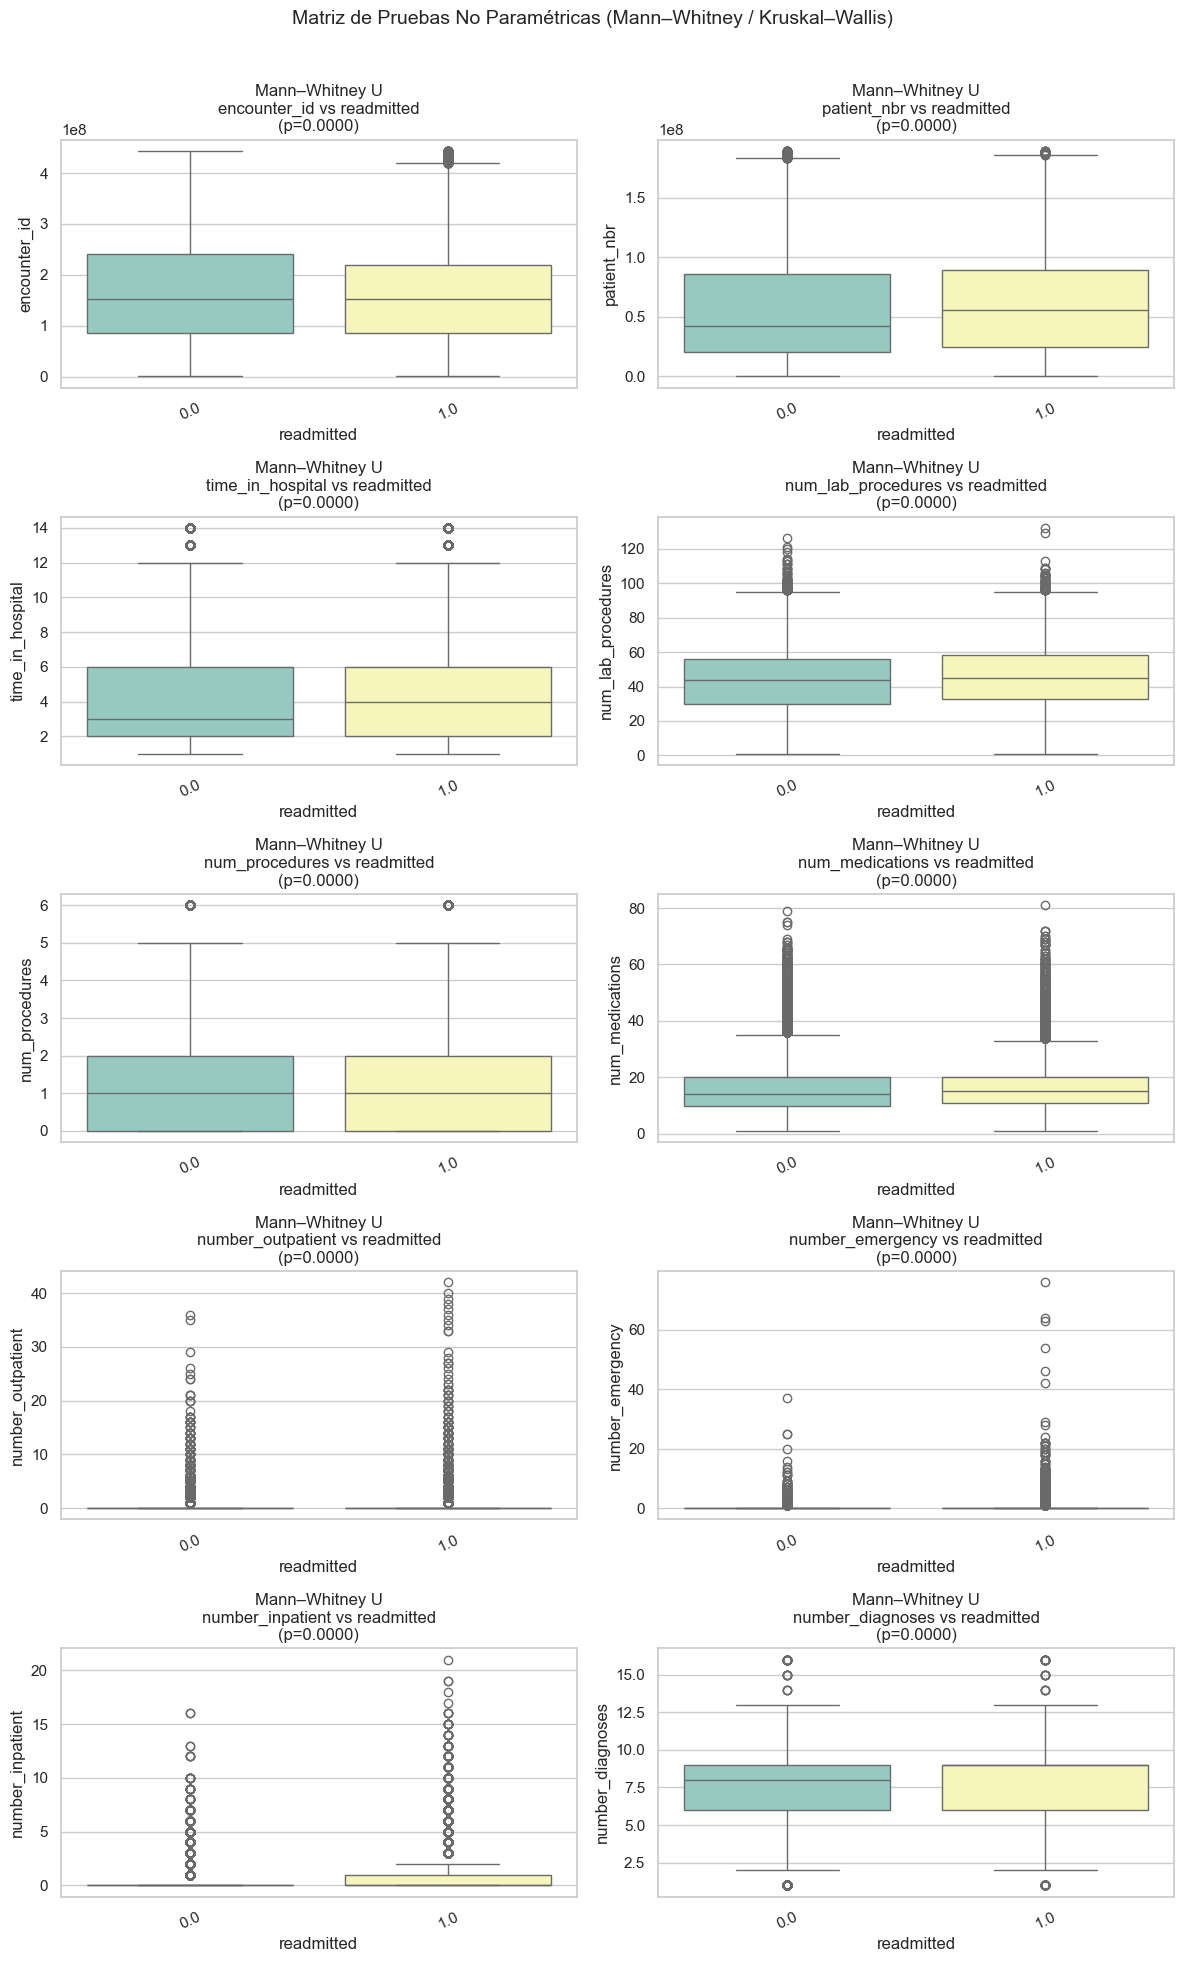

In [57]:
resultados = pruebas_no_parametricas(df, numeric_cols, ['readmitted'])

La prueba de Kruskal–Wallis se aplicó para evaluar si existen diferencias estadísticamente significativas en las variables numéricas del conjunto de datos entre los tres grupos definidos por la variable **readmitted**. Dado que los datos no seguían una distribución normal y además se detectaron varianzas desiguales en las pruebas previas, esta prueba no paramétrica fue la opción más adecuada.

En la tabla de resultados, todas las variables presentan valores de **p < 0.05**, lo que indica que se **rechaza la hipótesis nula (H₀)**, la cual planteaba que las medianas de los grupos eran iguales. Esto significa que, para todas las variables numéricas analizadas, **existen diferencias estadísticamente significativas** entre los grupos de readmisión. Es decir, las características como el tiempo en hospital, el número de procedimientos, medicamentos o visitas presentan distribuciones distintas dependiendo del tipo de readmisión del paciente.

En la matriz de boxplots se puede observar visualmente esta diferencia: las cajas no se superponen completamente entre los grupos, y los rangos intercuartílicos y medianas muestran desplazamientos notorios. Estos patrones refuerzan los resultados estadísticos, evidenciando que la readmisión tiene un efecto diferenciador sobre la mayoría de las variables numéricas del conjunto de datos.


#### **3.4. Prueba de Chi-cuadrado**

In [58]:
def prueba_chi_cuadrado(df, cat_vars=None, graficar=True):

    # Detección automática de variables categóricas
    if cat_vars is None:
        cat_vars = df.select_dtypes(exclude=[np.number]).columns.tolist()

    resultados = []
    chi_matrix = pd.DataFrame(index=cat_vars, columns=cat_vars, dtype=float)

    # Comparar cada par de variables categóricas
    for i, var1 in enumerate(cat_vars):
        for j, var2 in enumerate(cat_vars):
            if i >= j:  # Evitar duplicados y diagonal
                continue

            tabla = pd.crosstab(df[var1], df[var2])
            chi2, p, dof, expected = chi2_contingency(tabla)

            resultados.append({
                "Variable 1": var1,
                "Variable 2": var2,
                "Chi²": round(chi2, 3),
                "p_valor": round(p, 4),
                "Grados de libertad": dof,
                "Resultado": "Significativa" if p < 0.05 else "No significativa"
            })

            chi_matrix.loc[var1, var2] = chi2
            chi_matrix.loc[var2, var1] = chi2

    resultados_df = pd.DataFrame(resultados)

    print("✅ Pruebas Chi-cuadrado completadas.\n")
    display(resultados_df.style.background_gradient(cmap="YlGnBu", subset=["p_valor"]))

    # ---------------------------
    # Visualización: Heatmap Chi²
    # ---------------------------
    if graficar:
        plt.figure(figsize=(18, 16))
        sns.heatmap(chi_matrix.astype(float), annot=True, cmap="YlGnBu", fmt=".2f")
        plt.title("Matriz de asociación entre variables categóricas (Chi-cuadrado)", fontsize=13)
        plt.tight_layout()
        plt.show()

    return resultados_df, chi_matrix


✅ Pruebas Chi-cuadrado completadas.



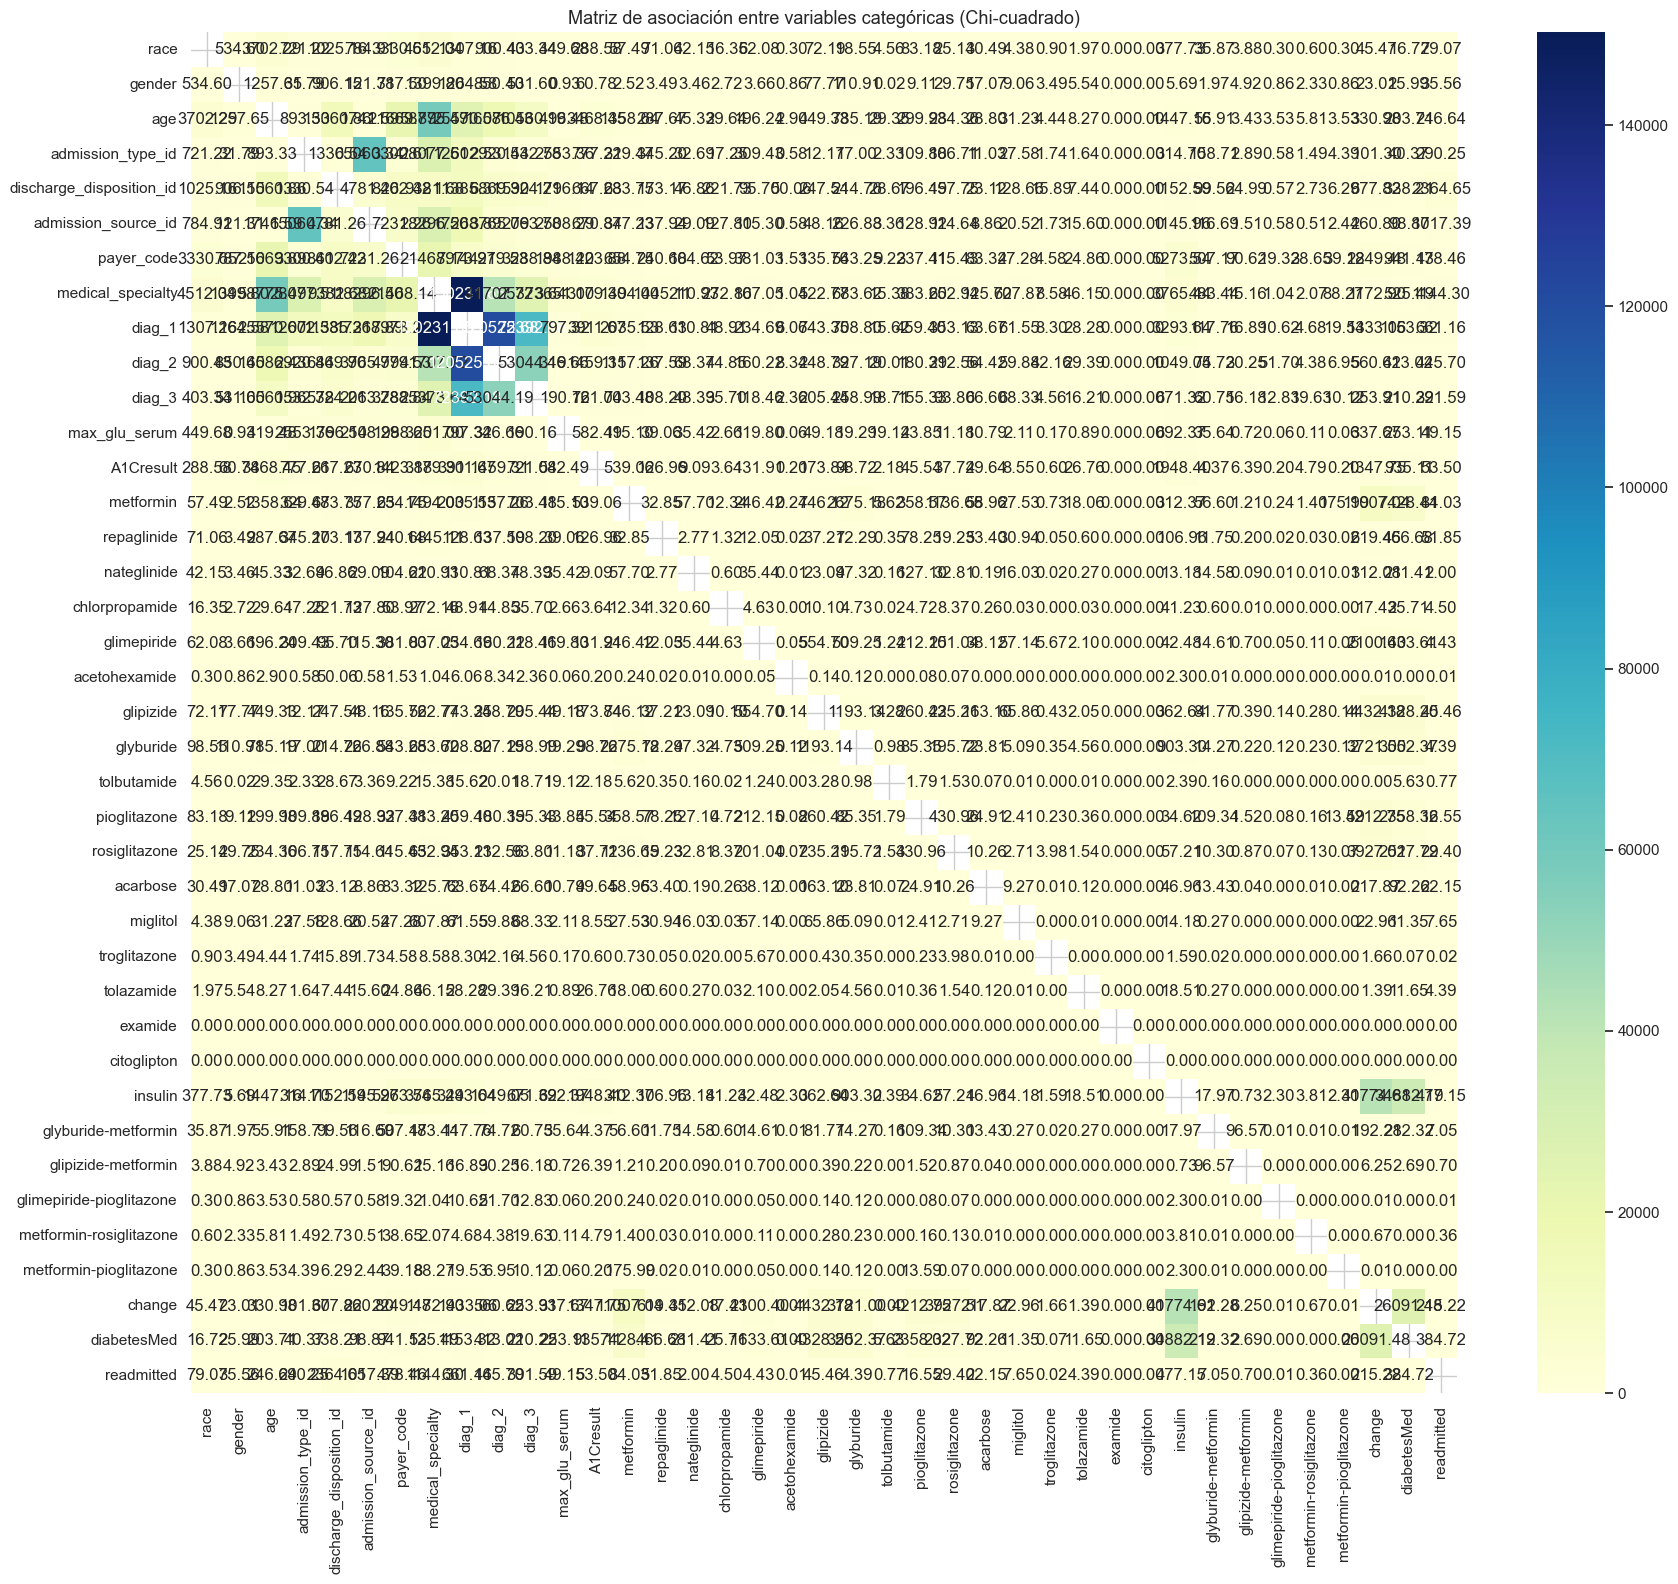

In [59]:
resultados_chi2, chi_matrix = prueba_chi_cuadrado(df, cat_cols)

La prueba de Chi-cuadrado se aplicó para analizar la relación entre las diferentes variables categóricas del conjunto de datos, especialmente para determinar si existe una asociación estadísticamente significativa entre ellas. En los resultados se observa que la mayoría de las combinaciones presentan valores de Chi-cuadrado muy elevados junto con valores p iguales a 0.0000, lo que indica que hay evidencia estadística suficiente para afirmar que las variables están asociadas entre sí y que sus distribuciones no son independientes. Esto significa que los patrones de respuesta en una variable dependen de los valores de la otra.

Por ejemplo, variables como **`change`**, **`diabetesMed`** y **`readmitted`** presentan asociaciones significativas, lo que sugiere que los cambios en el tratamiento o el uso de medicamentos para la diabetes están relacionados con la probabilidad de que un paciente sea readmitido. En cambio, otras relaciones como la de **`metformin-pioglitazone`** con **`readmitted`** no resultaron significativas (p = 0.6522), indicando que no existe una relación estadísticamente clara entre el uso conjunto de estos medicamentos y las readmisiones.

En la matriz de calor, los valores más altos de Chi-cuadrado se destacan en colores más intensos, lo que visualmente resalta las asociaciones más fuertes entre variables. Esta visualización permite identificar rápidamente qué variables tienden a variar juntas, ofreciendo una visión general de las dependencias dentro del conjunto de datos. En resumen, los resultados del Chi-cuadrado evidencian que varias variables categóricas tienen vínculos importantes, especialmente las relacionadas con los tratamientos y las condiciones médicas de los pacientes.


#### **3.5. Spearman**

In [60]:
def prueba_spearman(df, num_vars, cat_vars, graficar=True):
    
    resultados = []
    
    for var_x in num_vars:
        for var_y in cat_vars:
            # Asegurar que no haya valores faltantes
            datos = df[[var_x, var_y]].dropna()
            
            # Verificar que haya variación
            if datos[var_y].nunique() < 2:
                print(f"⚠️ La variable '{var_y}' no tiene variación. Se omite.")
                continue
            
            # Calcular Spearman
            coef, p_valor = spearmanr(datos[var_x], datos[var_y])
            
            # Guardar resultados
            resultados.append({
                'Variable X (num)': var_x,
                'Variable Y (cat/ord)': var_y,
                'Coeficiente ρ (Spearman)': round(coef, 3),
                'Valor p': round(p_valor, 4),
                'Conclusión': 'Significativa' if p_valor < 0.05 else 'No significativa'
            })
    
    # Crear tabla resumen
    resultados_df = pd.DataFrame(resultados)
    print("📊 Resultados de la prueba de Spearman:\n")
    display(resultados_df)
    
    # Generar gráficos en matriz
    if graficar and not resultados_df.empty:
        n = len(resultados_df)
        n_cols = 2
        n_rows = (n + n_cols - 1) // n_cols
        
        fig, axes = plt.subplots(n_rows, n_cols, figsize=(12, 5*n_rows))
        axes = axes.flatten()
        
        for i, row in enumerate(resultados_df.itertuples()):
            sns.regplot(x=row._1, y=row._2, data=df, scatter_kws={'alpha':0.6},
                        line_kws={'color':'red'}, lowess=True, ax=axes[i])
            axes[i].set_title(f"{row._1} vs {row._2}\nρ={row._3}, p={row._4}")
            axes[i].set_xlabel(row._1)
            axes[i].set_ylabel(row._2)
        
        # Quitar ejes vacíos si sobran
        for j in range(i+1, len(axes)):
            fig.delaxes(axes[j])
            
        plt.tight_layout()
        plt.show()
    
    return resultados_df


📊 Resultados de la prueba de Spearman:



Variable X (num) Variable Y (cat/ord)  Coeficiente ρ (Spearman)  Valor p  \
0        encounter_id           readmitted                    -0.022      0.0   
1         patient_nbr           readmitted                     0.088      0.0   
2    time_in_hospital           readmitted                     0.061      0.0   
3  num_lab_procedures           readmitted                     0.041      0.0   
4      num_procedures           readmitted                    -0.046      0.0   
5     num_medications           readmitted                     0.071      0.0   
6   number_outpatient           readmitted                     0.111      0.0   
7    number_emergency           readmitted                     0.126      0.0   
8    number_inpatient           readmitted                     0.229      0.0   
9    number_diagnoses           readmitted                     0.109      0.0   

      Conclusión  
0  Significativa  
1  Significativa  
2  Significativa  
3  Significativa  
4  Significativa  
5  Significativa  
6  Significativa  
7  Significativa  
8  Significativa  
9  Significativa

KeyboardInterrupt: 

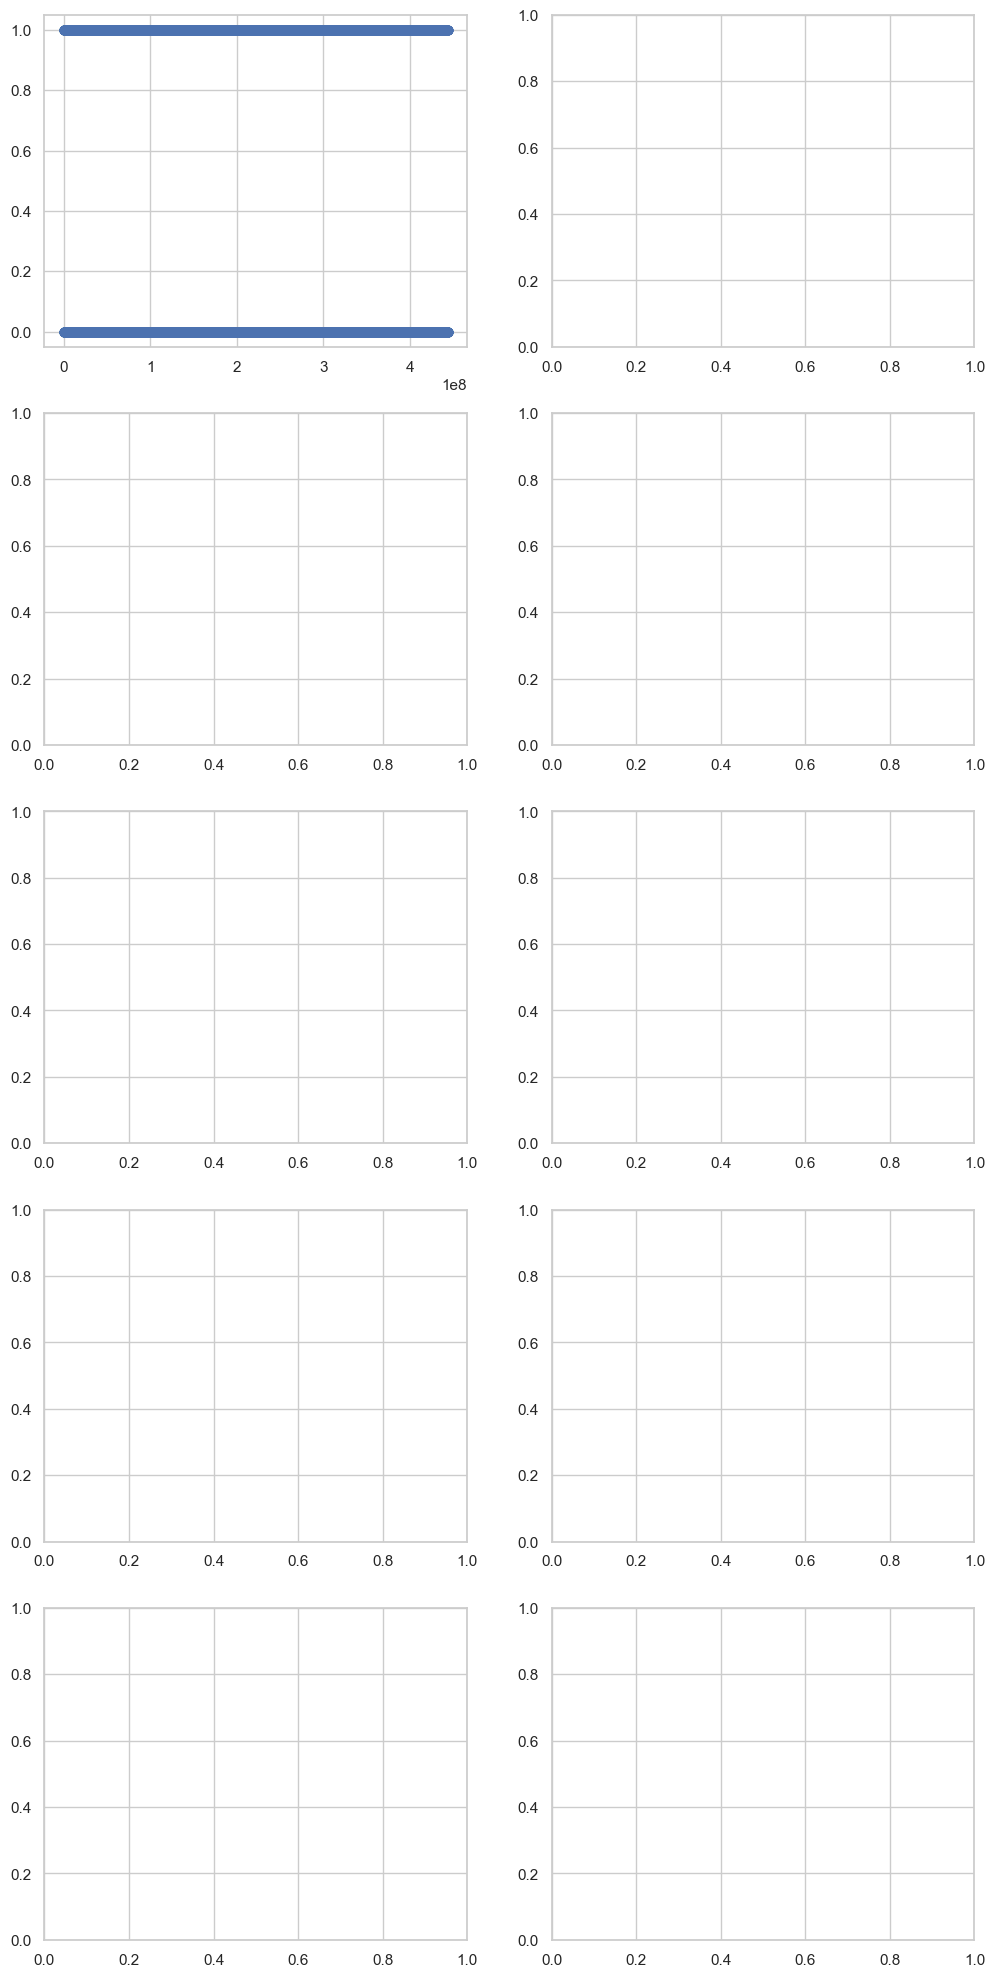

In [61]:
resultados_spearman = prueba_spearman(
    df=df,
    num_vars=numeric_cols,
    cat_vars=['readmitted']
)

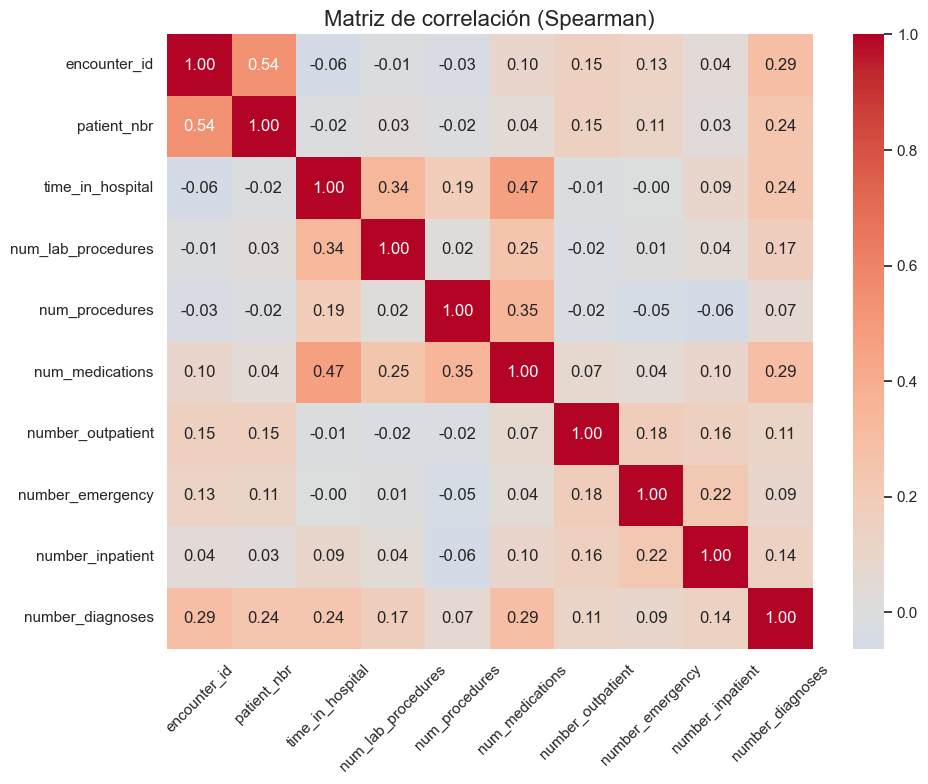

In [ ]:
def grafico_cor_spearman(df, title="Matriz de correlación (Spearman)"):
    # Seleccionar solo columnas numéricas
    df_num = df.select_dtypes(include='number')
    
    # Calcular la matriz de correlación de Spearman
    cor_matrix = df_num.corr(method='spearman')
    
    # Crear el heatmap
    plt.figure(figsize=(10,8))
    sns.heatmap(cor_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
    plt.title(title, fontsize=16)
    plt.xticks(rotation=45)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

# Ejemplo de uso:
grafico_cor_spearman(df)


En la matriz de correlación podemos observar que la mayoría de las correlaciones entre las variables numéricas son débiles o moderadas. Por ejemplo, existe una correlación moderada entre `time_in_hospital` y `num_medications` (ρ ≈ 0.47), lo cual indica que a mayor tiempo de hospitalización, tiende a haber un mayor número de medicamentos administrados. Asimismo, se observa una correlación moderada entre `num_medications` y `number_diagnoses` (ρ ≈ 0.29), lo cual es coherente, ya que más diagnósticos podrían requerir un tratamiento más complejo. También se destaca una correlación entre `num_lab_procedures` y `time_in_hospital` (ρ ≈ 0.34), lo cual sugiere que un mayor número de días hospitalizado podría asociarse con una mayor cantidad de procedimientos de laboratorio realizados.

En general, los valores de correlación no superan 0.5, lo cual sugiere que no existen relaciones lineales muy fuertes entre estas variables, aunque algunas asociaciones moderadas pueden ser relevantes para análisis posteriores.

## **4. Preprocesamiento:**

### **4.1 Cargando los datos postEDA:**

In [31]:
df.to_csv("data_post_eda.csv", index=False)

In [35]:
df=pd.read_csv("data_post_EDA.csv")
df.head()

encounter_id  patient_nbr  race  gender  age  admission_type_id  \
0       2278392      8222157   2.0     0.0  0.0                1.0   
1        149190     55629189   2.0     0.0  1.0                1.0   
2         64410     86047875   0.0     0.0  2.0                1.0   
3        500364     82442376   2.0     1.0  3.0                1.0   
4         16680     42519267   2.0     1.0  4.0                1.0   

   discharge_disposition_id  admission_source_id  time_in_hospital  \
0                       2.0                  3.0                 1   
1                       2.0                  0.0                 3   
2                       2.0                  0.0                 2   
3                       2.0                  0.0                 2   
4                       2.0                  0.0                 1   

   payer_code  medical_specialty  num_lab_procedures  num_procedures  \
0        16.0               37.0                  41               0   
1        16.0               71.0                  59               0   
2        16.0               71.0                  11               5   
3        16.0               71.0                  44               1   
4        16.0               71.0                  51               0   

   num_medications  number_outpatient  number_emergency  number_inpatient  \
0                1                  0                 0                 0   
1               18                  0                 0                 0   
2               13                  2                 0                 1   
3               16                  0                 0                 0   
4                8                  0                 0                 0   

   diag_1  diag_2  diag_3  number_diagnoses  max_glu_serum  A1Cresult  \
0     3.0     6.0     3.0                 1            3.0        3.0   
1     6.0     3.0     6.0                 9            3.0        3.0   
2     5.0     3.0     1.0                 6            3.0        3.0   
3     9.0     3.0     2.0                 7            3.0        3.0   
4    11.0    11.0     3.0                 5            3.0        3.0   

   metformin  repaglinide  nateglinide  chlorpropamide  glimepiride  \
0        1.0          1.0          1.0             1.0          1.0   
1        1.0          1.0          1.0             1.0          1.0   
2        1.0          1.0          1.0             1.0          1.0   
3        1.0          1.0          1.0             1.0          1.0   
4        1.0          1.0          1.0             1.0          1.0   

   acetohexamide  glipizide  glyburide  tolbutamide  pioglitazone  \
0            0.0        1.0        1.0          0.0           1.0   
1            0.0        1.0        1.0          0.0           1.0   
2            0.0        2.0        1.0          0.0           1.0   
3            0.0        1.0        1.0          0.0           1.0   
4            0.0        2.0        1.0          0.0           1.0   

   rosiglitazone  acarbose  miglitol  troglitazone  tolazamide  examide  \
0            1.0       1.0       1.0           0.0         0.0      0.0   
1            1.0       1.0       1.0           0.0         0.0      0.0   
2            1.0       1.0       1.0           0.0         0.0      0.0   
3            1.0       1.0       1.0           0.0         0.0      0.0   
4            1.0       1.0       1.0           0.0         0.0      0.0   

   citoglipton  insulin  glyburide-metformin  glipizide-metformin  \
0          0.0      1.0                  1.0                  0.0   
1          0.0      3.0                  1.0                  0.0   
2          0.0      1.0                  1.0                  0.0   
3          0.0      3.0                  1.0                  0.0   
4          0.0      2.0                  1.0                  0.0   

   glimepiride-pioglitazone  metformin-rosiglitazone  metformin-pioglitazone  \
0                       0.0           

In [36]:
df[cat_cols] = encoder.inverse_transform(df[cat_cols])
df.head()

encounter_id  patient_nbr             race  gender      age  \
0       2278392      8222157        Caucasian  Female   [0-10)   
1        149190     55629189        Caucasian  Female  [10-20)   
2         64410     86047875  AfricanAmerican  Female  [20-30)   
3        500364     82442376        Caucasian    Male  [30-40)   
4         16680     42519267        Caucasian    Male  [40-50)   

  admission_type_id discharge_disposition_id admission_source_id  \
0         Emergency                     Home            Referral   
1         Emergency                     Home       EmergencyRoom   
2         Emergency                     Home       EmergencyRoom   
3         Emergency                     Home       EmergencyRoom   
4         Emergency                     Home       EmergencyRoom   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1    Unknown  Pediatrics-Endocrinology                  41   
1                 3    Unknown                   Unknown                  59   
2                 2    Unknown                   Unknown                  11   
3                 2    Unknown                   Unknown                  44   
4                 1    Unknown                   Unknown                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient                                  diag_1  \
0                 0                                Diabetes   
1                 0  Endocrino y metabolismo (sin diabetes)   
2                 1                    Embarazo y puerperio   
3                 0              Infecciosas y parasitarias   
4                 0                              Neoplasmas   

                                   diag_2  \
0  Endocrino y metabolismo (sin diabetes)   
1                                Diabetes   
2                                Diabetes   
3                                Diabetes   
4                              Neoplasmas   

                                   diag_3  number_diagnoses max_glu_serum  \
0                                Diabetes                 1          none   
1  Endocrino y metabolismo (sin diabetes)                 9          none   
2                         Causas externas                 6          none   
3                            Circulatorio                 7          none   
4                                Diabetes                 5          none   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0      none        No          No          No             No          No   
1      none        No          No          No             No          No   
2      none        No          No          No             No          No   
3      none        No          No          No             No          No   
4      none        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No    Steady        No          No           No            No   
3            No        No        No          No           No            No   
4            No    Steady        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No      Up   
2

### **4.2 Reducción de Dimensiones:**

En esta sección, como su título lo indica, se analizará detalladamente la estructura de la base datos con el objetivo de reducir la dimensión original de esta. El objetivo principal de esta práctica es poder ejecutar los modelos que se presentan más adelante, pues debido a la alta dimensión se necesita mayor memoria RAM.

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 49 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   encounter_id              101766 non-null  int64 
 1   patient_nbr               101766 non-null  int64 
 2   race                      101766 non-null  object
 3   gender                    101766 non-null  object
 4   age                       101766 non-null  object
 5   admission_type_id         101766 non-null  object
 6   discharge_disposition_id  101766 non-null  object
 7   admission_source_id       101766 non-null  object
 8   time_in_hospital          101766 non-null  int64 
 9   payer_code                101766 non-null  object
 10  medical_specialty         101766 non-null  object
 11  num_lab_procedures        101766 non-null  int64 
 12  num_procedures            101766 non-null  int64 
 13  num_medications           101766 non-null  int64 
 14  numb

In [38]:
medicamentos =['metformin','repaglinide','nateglinide','chlorpropamide','glimepiride','acetohexamide','glipizide','glyburide','tolbutamide','pioglitazone','rosiglitazone','acarbose','miglitol','troglitazone','tolazamide','examide','citoglipton','insulin','glyburide-metformin','glipizide-metformin','glimepiride-pioglitazone','metformin-rosiglitazone','metformin-pioglitazone']

df[medicamentos] = df[medicamentos].replace({"Up":"Yes","Down":"Yes","Steady":"Yes"})

Ahora observemos las categorias de las variables ``diag_1``, ``diag_2`` y ``diag_3``.

In [39]:
df["diag_1"].unique()

array(['Diabetes', 'Endocrino y metabolismo (sin diabetes)',
       'Embarazo y puerperio', 'Infecciosas y parasitarias', 'Neoplasmas',
       'Circulatorio', 'Respiratorio', 'Herida',
       'Piel y tejido subcutáneo', 'Musculoesquelético', 'Digestivo',
       'Causas externas', 'Genitourinario', 'Trastornos mentales',
       'Síntomas mal definidos', 'Sistema nervioso',
       'Sangre y órganos hematopoyéticos', 'Otro',
       'Órganos de los sentidos', 'Anomalías congénitas'], dtype=object)

In [40]:
df["diag_2"].unique()

array(['Endocrino y metabolismo (sin diabetes)', 'Diabetes', 'Neoplasmas',
       'Circulatorio', 'Respiratorio', 'Sangre y órganos hematopoyéticos',
       'Herida', 'Musculoesquelético', 'Genitourinario',
       'Infecciosas y parasitarias', 'Digestivo',
       'Piel y tejido subcutáneo', 'Causas externas', 'Sistema nervioso',
       'Síntomas mal definidos', 'Trastornos mentales',
       'Embarazo y puerperio', 'Anomalías congénitas', 'Otro',
       'Órganos de los sentidos'], dtype=object)

In [41]:
df["diag_3"].unique()

array(['Diabetes', 'Endocrino y metabolismo (sin diabetes)',
       'Causas externas', 'Circulatorio', 'Infecciosas y parasitarias',
       'Respiratorio', 'Herida', 'Neoplasmas', 'Genitourinario',
       'Musculoesquelético', 'Síntomas mal definidos', 'Digestivo',
       'Piel y tejido subcutáneo', 'Trastornos mentales', 'Otro',
       'Anomalías congénitas', 'Sistema nervioso',
       'Órganos de los sentidos', 'Embarazo y puerperio',
       'Sangre y órganos hematopoyéticos'], dtype=object)

Note que estas variables comparten ciertas categorías y como al modelar se apica la técnica One-Hot-Encoding, al agrupar las categorías podría ayudarnos a reducir la dimensionaliad del dataset final.

In [42]:
categorias = pd.unique(df[["diag_1", "diag_2", "diag_3"]].values.ravel())

for cat in categorias:
    df[cat] = ((df["diag_1"] == cat) | 
               (df["diag_2"] == cat) | 
               (df["diag_3"] == cat)).astype(object)

# Verificar resultado
df.head()

encounter_id  patient_nbr             race  gender      age  \
0       2278392      8222157        Caucasian  Female   [0-10)   
1        149190     55629189        Caucasian  Female  [10-20)   
2         64410     86047875  AfricanAmerican  Female  [20-30)   
3        500364     82442376        Caucasian    Male  [30-40)   
4         16680     42519267        Caucasian    Male  [40-50)   

  admission_type_id discharge_disposition_id admission_source_id  \
0         Emergency                     Home            Referral   
1         Emergency                     Home       EmergencyRoom   
2         Emergency                     Home       EmergencyRoom   
3         Emergency                     Home       EmergencyRoom   
4         Emergency                     Home       EmergencyRoom   

   time_in_hospital payer_code         medical_specialty  num_lab_procedures  \
0                 1    Unknown  Pediatrics-Endocrinology                  41   
1                 3    Unknown                   Unknown                  59   
2                 2    Unknown                   Unknown                  11   
3                 2    Unknown                   Unknown                  44   
4                 1    Unknown                   Unknown                  51   

   num_procedures  num_medications  number_outpatient  number_emergency  \
0               0                1                  0                 0   
1               0               18                  0                 0   
2               5               13                  2                 0   
3               1               16                  0                 0   
4               0                8                  0                 0   

   number_inpatient                                  diag_1  \
0                 0                                Diabetes   
1                 0  Endocrino y metabolismo (sin diabetes)   
2                 1                    Embarazo y puerperio   
3                 0              Infecciosas y parasitarias   
4                 0                              Neoplasmas   

                                   diag_2  \
0  Endocrino y metabolismo (sin diabetes)   
1                                Diabetes   
2                                Diabetes   
3                                Diabetes   
4                              Neoplasmas   

                                   diag_3  number_diagnoses max_glu_serum  \
0                                Diabetes                 1          none   
1  Endocrino y metabolismo (sin diabetes)                 9          none   
2                         Causas externas                 6          none   
3                            Circulatorio                 7          none   
4                                Diabetes                 5          none   

  A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
0      none        No          No          No             No          No   
1      none        No          No          No             No          No   
2      none        No          No          No             No          No   
3      none        No          No          No             No          No   
4      none        No          No          No             No          No   

  acetohexamide glipizide glyburide tolbutamide pioglitazone rosiglitazone  \
0            No        No        No          No           No            No   
1            No        No        No          No           No            No   
2            No       Yes        No          No           No            No   
3            No        No        No          No           No            No   
4            No       Yes        No          No           No            No   

  acarbose miglitol troglitazone tolazamide examide citoglipton insulin  \
0       No       No           No         No      No          No      No   
1       No       No           No         No      No          No     Yes   
2

In [43]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 101766 entries, 0 to 101765
Data columns (total 69 columns):
 #   Column                                  Non-Null Count   Dtype 
---  ------                                  --------------   ----- 
 0   encounter_id                            101766 non-null  int64 
 1   patient_nbr                             101766 non-null  int64 
 2   race                                    101766 non-null  object
 3   gender                                  101766 non-null  object
 4   age                                     101766 non-null  object
 5   admission_type_id                       101766 non-null  object
 6   discharge_disposition_id                101766 non-null  object
 7   admission_source_id                     101766 non-null  object
 8   time_in_hospital                        101766 non-null  int64 
 9   payer_code                              101766 non-null  object
 10  medical_specialty                       101766 non-null 

Se eliminan las columnas de las variables transformadas anteriormente.

In [44]:
df = df.drop("diag_1",axis=1)
df= df.drop("diag_2",axis=1)
df = df.drop("diag_3",axis=1)

Sigamos examianndo la base de datos.

In [45]:
df.describe(include=["object", "category"])

race  gender      age admission_type_id discharge_disposition_id  \
count      101766  101766   101766            101766                   101766   
unique          5       3       10                 5                        7   
top     Caucasian  Female  [70-80)         Emergency                     Home   
freq        78372   54708    26068             64386                    77930   

       admission_source_id payer_code medical_specialty max_glu_serum  \
count               101766     101766            101766        101766   
unique                   5         18                73             4   
top          EmergencyRoom    Unknown           Unknown          none   
freq                 64561      40256             49949         96420   

       A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
count     101766    101766      101766      101766         101766      101766   
unique         4         2           2           2              2           2   
top         none        No          No          No             No          No   
freq       84748     81778      100227      101063         101680       96575   

       acetohexamide glipizide glyburide tolbutamide pioglitazone  \
count         101766    101766    101766      101766       101766   
unique             2         2         2           2            2   
top               No        No        No          No           No   
freq          101765     89080     91116      101743        94438   

       rosiglitazone acarbose miglitol troglitazone tolazamide examide  \
count         101766   101766   101766       101766     101766  101766   
unique             2        2        2            2          2       1   
top               No       No       No           No         No      No   
freq           95401   101458   101728       101763     101727  101766   

       citoglipton insulin glyburide-metformin glipizide-metformin  \
count       101766  101766              101766              101766   
unique           1       2                   2                   2   
top             No     Yes                  No                  No   
freq        101766   54383              101060              101753   

       glimepiride-pioglitazone metformin-rosiglitazone  \
count                    101766                  101766   
unique                        2                       2   
top                          No                      No   
freq                     101765                  101764   

       metformin-pioglitazone  change diabetesMed readmitted Diabetes  \
count                  101766  101766      101766     101766   101766   
unique                      2       2           2          2        2   
top                        No      No         Yes         No    False   
freq                   101765   54755       78363      54864    63581   

       Endocrino y metabolismo (sin diabetes) Embarazo y puerperio  \
count                                  101766               101766   
unique                                      2                    2   
top                                     False                False   
freq                                    82798               101074   

       Causas externas Infecciosas y parasitarias Circulatorio Neoplasmas  \
count           101766                     101766       101766     101766   
unique               2                          2            2          2   
top              False                      False         True      False   
freq             93297                      95435        59324      95678   

       Respiratorio  Herida Sangre y órganos hematopoyéticos Genitourinario  \
count        101766  101766                           101766         101766   
unique            2       2                                2              2   
top           False   False                            False          False   
freq          74896   91797                         

Podemos percatarnos que la variable ``medical_specialty`` cuenta con una alta cantidad de categorías, por lo que para disminuir la dimesnsión d la base de datos después del encoding, se agruparán ciertas categorías.

In [46]:
specialty_map = {
    # Medicina general / primaria
    "InternalMedicine": "General/Primary",
    "Family/GeneralPractice": "General/Primary",
    "PhysicianNotFound": "General/Primary",
    "Resident": "General/Primary",
    "Hospitalist": "General/Primary",
    "OutreachServices": "General/Primary",

    # Cirugía
    "Surgery-General": "Surgery",
    "Surgery-Cardiovascular/Thoracic": "Surgery",
    "Surgery-Neuro": "Surgery",
    "Surgery-Colon&Rectal": "Surgery",
    "Surgery-Plastic": "Surgery",
    "Surgery-Thoracic": "Surgery",
    "Surgery-PlasticwithinHeadandNeck": "Surgery",
    "Surgery-Pediatric": "Surgery",
    "Surgery-Vascular": "Surgery",
    "Surgery-Maxillofacial": "Surgery",
    "Surgeon": "Surgery",
    "SurgicalSpecialty": "Surgery",

    # Pediatría
    "Pediatrics": "Pediatrics",
    "Pediatrics-Endocrinology": "Pediatrics",
    "Pediatrics-CriticalCare": "Pediatrics",
    "Pediatrics-Pulmonology": "Pediatrics",
    "Pediatrics-Hematology-Oncology": "Pediatrics",
    "Pediatrics-Neurology": "Pediatrics",
    "Pediatrics-EmergencyMedicine": "Pediatrics",
    "Pediatrics-InfectiousDiseases": "Pediatrics",
    "Pediatrics-AllergyandImmunology": "Pediatrics",
    "Anesthesiology-Pediatric": "Pediatrics",
    "Cardiology-Pediatric": "Pediatrics",

    # Ginecología y obstetricia
    "ObstetricsandGynecology": "Gynecology/Obstetrics",
    "Obsterics&Gynecology-GynecologicOnco": "Gynecology/Obstetrics",
    "Obstetrics": "Gynecology/Obstetrics",
    "Gynecology": "Gynecology/Obstetrics",
    "Perinatology": "Gynecology/Obstetrics",

    # Medicina interna - subespecialidades
    "Cardiology": "InternalMedicine-Subspecialty",
    "Pulmonology": "InternalMedicine-Subspecialty",
    "Nephrology": "InternalMedicine-Subspecialty",
    "Endocrinology": "InternalMedicine-Subspecialty",
    "Endocrinology-Metabolism": "InternalMedicine-Subspecialty",
    "Gastroenterology": "InternalMedicine-Subspecialty",
    "Hematology": "InternalMedicine-Subspecialty",
    "Oncology": "InternalMedicine-Subspecialty",
    "Hematology/Oncology": "InternalMedicine-Subspecialty",
    "Rheumatology": "InternalMedicine-Subspecialty",
    "InfectiousDiseases": "InternalMedicine-Subspecialty",
    "AllergyandImmunology": "InternalMedicine-Subspecialty",
    "PhysicalMedicineandRehabilitation": "InternalMedicine-Subspecialty",
    "SportsMedicine": "InternalMedicine-Subspecialty",
    "Proctology": "InternalMedicine-Subspecialty",

    # Neurología y salud mental
    "Neurology": "Neuro/MentalHealth",
    "Neurophysiology": "Neuro/MentalHealth",
    "Psychiatry": "Neuro/MentalHealth",
    "Psychiatry-Child/Adolescent": "Neuro/MentalHealth",
    "Psychiatry-Addictive": "Neuro/MentalHealth",
    "Psychology": "Neuro/MentalHealth",

    # Especialidades diagnósticas
    "Radiology": "Diagnostics",
    "Radiologist": "Diagnostics",
    "Pathology": "Diagnostics",
    "Speech": "Diagnostics",

    # Otros
    "Dentistry": "Other",
    "Ophthalmology": "Other",
    "Otolaryngology": "Other",
    "Podiatry": "Other",
    "Dermatology": "Other",
    "Osteopath": "Other",
    "Anesthesiology": "Other",
    "DCPTEAM": "Other",
    "Unknown": "Other"
}

df_copy=df.copy() 

# Reemplazar directamente en la columna original
df["medical_specialty"] = df["medical_specialty"].map(specialty_map)

# En caso de valores no encontrados en el diccionario, marcarlos como "Other"
df["medical_specialty"] = df["medical_specialty"].fillna("Other")

# Ver resultados
print(df["medical_specialty"].value_counts())

medical_specialty
Other                            61255
General/Primary                  22157
InternalMedicine-Subspecialty     9619
Surgery                           5011
Diagnostics                       1211
Neuro/MentalHealth                1167
Gynecology/Obstetrics              774
Pediatrics                         572
Name: count, dtype: int64


Finalmente, la variable ``medical_specialty`` cuenta con solo 8 categorías.

In [47]:
df.describe(include=["category", "object"])

race  gender      age admission_type_id discharge_disposition_id  \
count      101766  101766   101766            101766                   101766   
unique          5       3       10                 5                        7   
top     Caucasian  Female  [70-80)         Emergency                     Home   
freq        78372   54708    26068             64386                    77930   

       admission_source_id payer_code medical_specialty max_glu_serum  \
count               101766     101766            101766        101766   
unique                   5         18                 8             4   
top          EmergencyRoom    Unknown             Other          none   
freq                 64561      40256             61255         96420   

       A1Cresult metformin repaglinide nateglinide chlorpropamide glimepiride  \
count     101766    101766      101766      101766         101766      101766   
unique         4         2           2           2              2           2   
top         none        No          No          No             No          No   
freq       84748     81778      100227      101063         101680       96575   

       acetohexamide glipizide glyburide tolbutamide pioglitazone  \
count         101766    101766    101766      101766       101766   
unique             2         2         2           2            2   
top               No        No        No          No           No   
freq          101765     89080     91116      101743        94438   

       rosiglitazone acarbose miglitol troglitazone tolazamide examide  \
count         101766   101766   101766       101766     101766  101766   
unique             2        2        2            2          2       1   
top               No       No       No           No         No      No   
freq           95401   101458   101728       101763     101727  101766   

       citoglipton insulin glyburide-metformin glipizide-metformin  \
count       101766  101766              101766              101766   
unique           1       2                   2                   2   
top             No     Yes                  No                  No   
freq        101766   54383              101060              101753   

       glimepiride-pioglitazone metformin-rosiglitazone  \
count                    101766                  101766   
unique                        2                       2   
top                          No                      No   
freq                     101765                  101764   

       metformin-pioglitazone  change diabetesMed readmitted Diabetes  \
count                  101766  101766      101766     101766   101766   
unique                      2       2           2          2        2   
top                        No      No         Yes         No    False   
freq                   101765   54755       78363      54864    63581   

       Endocrino y metabolismo (sin diabetes) Embarazo y puerperio  \
count                                  101766               101766   
unique                                      2                    2   
top                                     False                False   
freq                                    82798               101074   

       Causas externas Infecciosas y parasitarias Circulatorio Neoplasmas  \
count           101766                     101766       101766     101766   
unique               2                          2            2          2   
top              False                      False         True      False   
freq             93297                      95435        59324      95678   

       Respiratorio  Herida Sangre y órganos hematopoyéticos Genitourinario  \
count        101766  101766                           101766         101766   
unique            2       2                                2              2   
top           False   False                            False          False   
freq          74896   91797                         

Y por último, se descartan ciertas columnas que no aportan mucha información al objetivo del proyecto. Las variables ``encounter_id``, ``payer_code`` y ``patient_nbr`` son categorías únicas; por su parte las columnas ``examide`` y ``citoglipton`` solo cuentan con una categoría que indica la ausenica de la misma. Y la variable ``diabetesMed`` se deja a un lado debido a que anterioremente se reescribió.

In [48]:
df = df.drop("encounter_id",axis=1)
df = df.drop("patient_nbr",axis=1)
df = df.drop("examide",axis=1)
df = df.drop("citoglipton",axis=1)
df = df.drop("payer_code", axis=1)
df = df.drop("diabetesMed",axis=1)

In [49]:
df.head()

race  gender      age admission_type_id  \
0        Caucasian  Female   [0-10)         Emergency   
1        Caucasian  Female  [10-20)         Emergency   
2  AfricanAmerican  Female  [20-30)         Emergency   
3        Caucasian    Male  [30-40)         Emergency   
4        Caucasian    Male  [40-50)         Emergency   

  discharge_disposition_id admission_source_id  time_in_hospital  \
0                     Home            Referral                 1   
1                     Home       EmergencyRoom                 3   
2                     Home       EmergencyRoom                 2   
3                     Home       EmergencyRoom                 2   
4                     Home       EmergencyRoom                 1   

  medical_specialty  num_lab_procedures  num_procedures  num_medications  \
0        Pediatrics                  41               0                1   
1             Other                  59               0               18   
2             Other                  11               5               13   
3             Other                  44               1               16   
4             Other                  51               0                8   

   number_outpatient  number_emergency  number_inpatient  number_diagnoses  \
0                  0                 0                 0                 1   
1                  0                 0                 0                 9   
2                  2                 0                 1                 6   
3                  0                 0                 0                 7   
4                  0                 0                 0                 5   

  max_glu_serum A1Cresult metformin repaglinide nateglinide chlorpropamide  \
0          none      none        No          No          No             No   
1          none      none        No          No          No             No   
2          none      none        No          No          No             No   
3          none      none        No          No          No             No   
4          none      none        No          No          No             No   

  glimepiride acetohexamide glipizide glyburide tolbutamide pioglitazone  \
0          No            No        No        No          No           No   
1          No            No        No        No          No           No   
2          No            No       Yes        No          No           No   
3          No            No        No        No          No           No   
4          No            No       Yes        No          No           No   

  rosiglitazone acarbose miglitol troglitazone tolazamide insulin  \
0            No       No       No           No         No      No   
1            No       No       No           No         No     Yes   
2            No       No       No           No         No      No   
3            No       No       No           No         No     Yes   
4            No       No       No           No         No     Yes   

  glyburide-metformin glipizide-metformin glimepiride-pioglitazone  \
0                  No                  No                       No   
1                  No                  No                       No   
2                  No                  No                       No   
3                  No                  No                       No   
4                  No                  No                       No   

  metformin-rosiglitazone metformin-pioglitazone change readmitted Diabetes  \
0                      No                     No     No         No     True   
1                      No                     No    Yes        Yes     True   
2                      No                     No     No         No     True   
3                      No                     No    Yes         No     True   
4                      No                     No    Yes         No     True   

  Endocrino y metabolismo (sin diabetes) Embarazo y puerperio Causas externas  \
0                 